# LSST False Detections

This notebook contains a False Detection generator for the LSST opsim based Sythetic Solar System Object Observation Catalog based on preliminary HiTS survey performance studies of the AP-pipeline team. 

In [46]:
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

In [47]:
import numpy as np

In [48]:
from scipy.spatial import cKDTree

In [49]:
from scipy.optimize import curve_fit

In [50]:
from sklearn.neighbors import KernelDensity

In [51]:
from astropy.coordinates import cartesian_to_spherical

In [52]:
import joblib
from joblib.externals.loky import set_loky_pickler
from joblib import parallel_backend
from joblib import wrap_non_picklable_objects
from joblib import Parallel, delayed

In [53]:

from lsst.sims.utils import ObservationMetaData
from lsst.sims.coordUtils import lsst_camera
from lsst.sims.coordUtils import chipNameFromRaDecLSST
from lsst.afw.cameraGeom import DetectorType

In [54]:
def sample_spherical(npoints, ndim=3):
    """Sample n points randomly (uniform distribution) on the unit (hyper-)sphere.
    
    Parameters:
    -----------
    npoints ... number of sampled points
    ndim    ... dimension of hyper-sphere
    
    Returns:
    --------
    vec ... numpy array of npoints x ndim vectors 
    """
    vec = np.random.randn(ndim, npoints)
    vec /= np.linalg.norm(vec, axis=0)
    return vec.T

In [68]:
def diaFalseDetectionVmag(nNoise, Vlim, eta0=5):
    """Noise V magnitude of Difference Imaging Artefacts following Veres & Chesley (2017).
    
    Parameters:
    -----------
    nNoise ... number of artifacts
    Vlim   ... m5 liming magntide at eta0=5
    eta0   ... Signal To Noise ratio limit for detection 
    
    Returns:
    --------
    V ... array containing nNoise Vmag values
    """
    
    p=np.random.random_sample(nNoise)
    eta = eta0*(1./(1.-p)**2)**(1./3.)
    V = Vlim - 2.5*np.log(eta/eta0)
    
    return V

In [172]:
def radec2icrfu(ra, dec, deg=True):
    """Convert Right Ascension and Declination to ICRF xyz unit vector.
    Geometric states on unit sphere, no light travel time/aberration correction.
    Parameters:
    -----------
    ra ... Right Ascension [deg]
    dec ... Declination [deg]
    deg ... True: angles in degrees, False: angles in radians
    
    Returns:
    --------
    x,y,z ... 3D vector of unit length (ICRF)
    """
    
    deg2rad=np.deg2rad
    array=np.array
    cos=np.cos
    sin=np.sin
    
    if(deg):
        a = deg2rad(ra)
        d = deg2rad(dec)
    else:
        a = array(ra)
        d = array(dec)
       
    cosd = cos(d)
    x = cosd*cos(a)
    y = cosd*sin(a)
    z = sin(d)

    return array([x, y, z])
   

In [220]:
def icrf2radec(x, y, z, deg=True):
    """Convert ICRF xyz to Right Ascension and Declination.
    Geometric states on unit sphere, no light travel time/aberration correction.
    
    Parameters:
    -----------
    x,y,z ... 3D vector of unit length (ICRF)
    deg ... True: angles in degrees, False: angles in radians
    
    Returns:
    --------
    ra ... Right Ascension [deg]
    dec ... Declination [deg]
    """
    
    norm=np.linalg.norm
    array=np.array
    arctan2=np.arctan2
    arcsin=np.arcsin
    rad2deg=np.rad2deg
    modulo=np.mod
    pix2=2.*np.pi
    
    pos=array([x,y,z])
    if(pos.ndim>1):
        r=norm(pos,axis=0)
    else:
        r=norm(pos)
    
    xu=x/r
    yu=y/r
    zu=z/r
    
    phi=arctan2(yu,xu)
    delta=arcsin(zu)
    
    if(deg):
        ra = modulo(rad2deg(phi)+360,360)
        dec = rad2deg(delta)
    else:
        ra = modulo(phi+pix2,pix2)
        dec = delta
        
    return ra, dec

In [76]:
def cameraFootprintFilter(ephems,obsdf,raname='fieldRA',decname='fieldDec',obsIdname='observationId', 
                   obsepochname='observationStartMJD',rotskyname='rotSkyPos',
                         raNameEph='AstRA(deg)',decNameEph='AstDec(deg)',
                         obsIdNameEph='observationId'):

    camera = lsst_camera()
    ccd_type_dict = {DetectorType.SCIENCE: 'science', DetectorType.WAVEFRONT: 'wavefront',
                 DetectorType.GUIDER: 'guider', DetectorType.FOCUS: 'focus'}
    
    ephemsFiltered=[]
    i=0
    for index, row in obsdf.iterrows(): 

        obs_metadata = ObservationMetaData(pointingRA=row[raname],
                                           pointingDec=row[decname],
                                           rotSkyPos=row[rotskyname],
                                           mjd=row[obsepochname])

        ephems_sel=ephems[ephems[obsIdNameEph] == row[obsIdname]].reset_index(drop=True)

        
        chipName = chipNameFromRaDecLSST(ra=ephems_sel[raNameEph].values.astype(float),
                                         dec=ephems_sel[decNameEph].values.astype(float),
                                            epoch=2000.0, obs_metadata=obs_metadata)


        idx=np.where(chipName != None)[0]
        idxObs=[i for i in idx if (ccd_type_dict[camera[chipName[i]].getType()] == 'science')]
        ephemsFiltered.append(ephems_sel[ephems_sel.index.isin(idxObs)])
    
    ephemsOut=pd.concat(ephemsFiltered).reset_index(drop=True)
    return ephemsOut

In [77]:
def getSqlData(database,rows_start,nrows):
    """Import dataset from local SQL database
    
    Parameters:
    -----------
    database   ... path to database
    rows_start ... number of row to start
    rows_max   ... number of rows to select
    
    Returns:
    --------
    observations ... pandas dataframe containing observations from JPL database
    """
    con = sql.connect(database)
    observations = pd.read_sql("""SELECT * FROM SummaryAllProps LIMIT """+str(rows_start)+','+str(nrows), con)
    return observations

In [78]:
def makeFalseDetections(rowStart,nRows,db_path,fitFunc,popt,pcov,kde):

    LSSTdf=getSqlData(db_path,rowStart,nRows)
    FDdf, nFDlist =createDiaFalseDetectionsHiTS(LSSTdf, fitFunc, popt, pcov,  kde)
    ephemsFiltered=cameraFootprintFilter(FDdf,LSSTdf,raname='fieldRA',decname='fieldDec',obsIdname='observationId', 
                   obsepochname='observationStartMJD',rotskyname='rotSkyPos')

    return ephemsFiltered

In [315]:
def makeFalseDetectionsFilesHiTS(rowStart,nRows,db_path,fitFunc,popt,pcov,kde):

    LSSTdf=getSqlData(db_path,rowStart,nRows)
    #FDdf=createDiaFalseDetections(LSSTdf)
    FDdf, nFDlist =createDiaFalseDetectionsHiTS(LSSTdf, fitFunc, popt, pcov,  kde)
    ephemsFiltered=cameraFootprintFilter(FDdf,LSSTdf,raname='fieldRA',decname='fieldDec',obsIdname='observationId', 
                   obsepochname='observationStartMJD',rotskyname='rotSkyPos')
    outfile='./data/false_detections_fbs-v1_5-2snaps_'+str(rowStart).zfill(7)+'.csv'
    ephemsFiltered.to_csv(outfile,index=False)
    #outfile='./data/false_detections_fbs_v1_5_2snaps-'+str(rowStart).zfill(7)+'.h5'
    #ephemsFiltered.to_hdf(outfile, key='df', mode='w')
    return 'Ok'


In [316]:
def makeFalseDetectionsFiles(rowStart,nRows,db_path):
    LSSTdf=getSqlData(db_path,rowStart,nRows)
    FDdf, nFDlist=createDiaFalseDetections(LSSTdf,minFD=350,maxFD=440)
    FDFiltered=cameraFootprintFilter(FDdf,LSSTdf,raname='fieldRA',decname='fieldDec',obsIdname='observationId', 
                   obsepochname='observationStartMJD',rotskyname='rotSkyPos')
    outfile='./data/false_detections_fbs-v1_5-2snaps_'+str(rowStart).zfill(7)+'.csv'
    FDFiltered.to_csv(outfile,index=False)
    return 'Ok'

In [325]:
def makeRandomNoiseFiles(rowStart,nRows,db_path):
    LSSTdf=getSqlData(db_path,rowStart,nRows)
    NSdf, nNSlist=createRandomNoise(LSSTdf,nLim=1000)
    NSFiltered=cameraFootprintFilter(NSdf,LSSTdf,raname='fieldRA',decname='fieldDec',obsIdname='observationId', 
                   obsepochname='observationStartMJD',rotskyname='rotSkyPos')
    outfile='./data/random_noise_fbs-v1_5-2snaps_'+str(rowStart).zfill(7)+'.csv'
    NSFiltered.to_csv(outfile,index=False)
    return 'Ok'

In [80]:
def flux2mag(f,  f0=3631):
    """AB ugriz system (f0 = 3631 Jy) to magnitude conversion

       Parameters:
       -----------
       f  ... flux [Jy]
       f0 ... zero point flux
   
       Returns:
       --------
       mag ... pogson magnitude
    """
    mag=-2.5*np.log10(f/f0)
    
    return mag

In [177]:
def createDiaFalseDetectionsHiTS(obsdf, fitFunc, popt, pcov,  kde, realBogusRatio=0.25, rsky=2.1,
                                 nFDlim=3500, seed=2020,
                                 raName='fieldRA',decName='fieldDec',obsIdName='observationId', 
                                 obsEpochName='observationStartMJD',limMagName='fiveSigmaDepth',
                                 seeingName='seeingFwhm500',filterName='filter',fieldIdName='fieldId',
                                 outCols=['ObjID','observationId', 'FieldMJD', 'AstRange(km)', 
                                'AstRangeRate(km/s)', 'AstRA(deg)','AstRARate(deg/day)',
                                'AstDec(deg)', 'AstDecRate(deg/day)', 'Ast-Sun(J2000x)(km)',
                                'Ast-Sun(J2000y)(km)', 'Ast-Sun(J2000z)(km)', 
                                'Sun-Ast-Obs(deg)', 'V','Filtermag','V(H=0)', 'Filter']):

    """Create simulated Difference Image Artifact (DIA) False Detections given a Real/Bogus ratio, a fit for
    the number of DIA sources as a function of seeing, and a Kernel density estimate for the DIA
    magnitude distribution. The function returns squares in RA and DEC 
    with side lenghts of 2*rsky [deg].
    
    Parameters:
    -----------
    obsdf             ... pandas DataFrame containing LSST observations (from opsim)
    fitFunc           ... DECam HiTS 2015 fit function for seeing vs number of DIA sources
    popt              ... optimum parameters for fitFunc
    pcov              ... covariance matrix for fitFunc
    kde               ... scikit learn kernel density estimate for DECam HiTS2015 filterMag distribution of DIA sources
    realBogusRatio    ... ratio of real/bogus values
    rsky              ... semilength of sky area (4*rsky^2) 
    nFDlim            ... limit number of False Detections per square degree
    seed              ... seed for numpy.random
    raname            ... field name for Right Ascension 
    decname           ... field name for Declination
    obsIdname         ... field name for observation ID
    obsepochname      ... field name for observation epoch
    limMagName        ... field name for limiting magnitude
    
    Returns:
    --------
    FDdf             ... pandas DataFrame with noise positions in RADEC
    nFDlist          ... list of number of false detections per square degree for every LSST visit/exposure
    """

    np.random.seed(seed)
    listdf = []
    nFDlist = []
    for index, row in obsdf.iterrows():
        
        #determine the number of noise DIA sources per visit in a field
        # Number of False Detections = square area on the sky [deg^2] * Normal_Distribution(meanNoise,sigmaNoise)/deg^2
        seeing=row[seeingName]
        
        # If number of FDs per square degrees > than limit, redraw.
        nFDPerSquareDeg=nFDlim+1
        while (nFDPerSquareDeg>nFDlim):
            par=np.random.multivariate_normal(popt,pcov,1)[0]
            nFDPerSquareDeg=fitFunc(seeing,par[0],par[1],par[2])*(1.-realBogusRatio)
            
        nFD=np.rint((2.*rsky)**2*nFDPerSquareDeg).astype(int)
        
        #print(nFD)
        # distribute FDs on sky 
        x=np.random.uniform(row[raName]-rsky,row[raName]+rsky,nFD)
        y=np.random.uniform(row[decName]-rsky,row[decName]+rsky,nFD)
        xy=np.array([x,y]).T

        # Determine filter mag of 
        filterMag=kde.sample(2).flatten()
        
        df=pd.DataFrame(index=range(nFD),columns=outCols)
        #df=pd.DataFrame(xy,columns = ['AstRA(deg)','AstDec(deg)'])
        df[['AstRA(deg)','AstDec(deg)']]=xy
        df['FieldMJD'] = row[obsEpochName]
        df['ObjID']='FD'
        df['Filtermag'] = filterMag[0:nFD]
        df['Filter']=row[filterName]
        df['observationId'] = row[obsIdName]
        
        
        listdf.append(df)
        nFDlist.append(nFDPerSquareDeg)

    FDdf=pd.concat(listdf).reset_index(drop=True)
    
    
    print('mean, sigma of number of False Detections per square degree', 
          int(np.mean(np.array(nFDlist))),',',int(np.std(np.array(nFDlist))))
    return FDdf, nFDlist

In [82]:
def nDIAvsSeeing(df_5sig):
    """Calculate number of DIA sources as a function of seeing from DECam HiTS data."""
    
    df_flux_gr=df_5sig.groupby('visit')
    nDia=df_flux_gr['ccd'].count()
    median_seeing=df_flux_gr['seeing'].median()
    dfnew=pd.DataFrame(nDia.values/3,columns=['nDIA_per_visit_per_sq_deg'])
    dfnew['median_seeing_arcsec']=median_seeing.values*0.26
    dfnew.sort_values('median_seeing_arcsec',inplace=True)
    df_dia=dfnew.reset_index(drop=True)
      
    return df_dia

In [248]:
def calcAstrometricError(mag, m5, nvisit=1, FWHMeff=700.0, error_sys = 10.0, astErrCoeff=0.60, output_units='mas'):
    """Calculate the astrometric error, for object catalog purposes.
    The effective FWHMeff MUST BE given in miliarcsec (NOT arcsec!).
    Systematic error, error_sys, must be given in miliarcsec.
    
    Parameters:
    -----------
        mag            ...    magnitude of the observation
        m5             ...    5 sigma limiting magnitude
        nvisit         ...    number of visits to consider
        FWHMeff        ...    effective Full Width at Half Maximum of Point Spread Function [mas]
        error_sys      ...    sytstematic error [mas]
        output_units   ...    'mas' (default): milliarcseconds, 'arcsec': arcseconds
    
    Returns:
    ---------
        astrom_error   ...    astrometric error 
        SNR            ...    signal to noise ratio
        error_rand     ...    random error
        
    *** This error corresponds to a single-coordinate error ***
    the total astrometric error (e.g. relevant when
    matching two catalogs) will be sqrt(2) times larger!
    """
    # The astrometric error can be applied to parallax or proper motion (for nvisit>1).
    # If applying to proper motion, should also divide by the # of years of the survey.
    # This is also referenced in the LSST overview paper (arXiv:0805.2366, ls.st/lop)
    #
    # Notes:
    # - assumes sqrt(Nvisit) scaling, which is the best-case scenario
    # - calcRandomAstrometricError assumes maxiumm likelihood solution,
    # which is also the best-case scenario
    # - the systematic error, error_sys = 10 mas, corresponds to the
    # design spec from the LSST Science Requirements Document (ls.st/srd)
    #
    # first compute SNR
    
    power=np.power
    sqrt=np.sqrt
    
    
    rgamma = 0.039
    xval = power(10, 0.4*(mag-m5))
    SNR = 1./sqrt((0.04-rgamma)*xval + rgamma*xval*xval)
    # random astrometric error for a single visit
    error_rand = calcRandomAstrometricErrorPerCoord(FWHMeff, SNR, astErrCoeff)
    # random astrometric error for nvisit observations
    if (nvisit > 1):
        error_rand = error_rand / sqrt(nvisit)
    # add systematic error floor:
    astrom_error = sqrt(error_sys * error_sys + error_rand*error_rand)
    
    if (output_units=='arcsec'):
        astrom_error=astrom_error/1000
        error_rand=error_rand/1000
    
    return astrom_error, SNR, error_rand

def calcRandomAstrometricErrorPerCoord(FWHMeff, SNR, AstromErrCoeff = 0.60):
    """Calculate the random astrometric error, as a function of
    effective FWHMeff and signal-to-noise ratio SNR
    Returns astrometric error in the same units as FWHM.
    ** This error corresponds to a single-coordinate error **
    the total astrometric error (e.g. relevant when matching
    two catalogs) will be sqrt(2) times larger.

    The coefficient AstromErrCoeff for Maximum Likelihood
    solution is given by 
       AstromErrCoeff = <P^2> / <|dP/dx|^2> * 1/FWHMeff
    where P is the point spread function, P(x,y). 

    For a single-Gaussian PSF, AstromErrCoeff = 0.60
    For a double-Gaussian approximation to Kolmogorov 
    seeing, AstromErrCoeff = 0.55; however, given the 
    same core seeing (FWHMgeom) as for a single-Gaussian
    PSF, the resulting error will be 36% larger because
    FWHMeff is 1.22 times larger and SNR is 1.22 times
    smaller, compared to error for single-Gaussian PSF.
    Although Kolmogorov seeing is a much better approximation
    of the free atmospheric seeing than single Gaussian seeing, 
    the default value of AstromErrCoeff is set to the
    more conservative value.
    Note also that AstromErrCoeff = 1.0 is often used in
    practice to empirically account for other error sources.

    The <June2020 version of this code used AstromErrCoeff=1.0
    and FWHMgeom instead of FWHMeff. Given that 
    FWHMeff/FWHMgeom=1.22 for Kolmogorov seeing, the old 
    version was within 3% from the total astrometric error 
    (that is, not error per coordinate, but sqrt(2) larger)
    produced with this updated version.
    """
    return AstromErrCoeff * FWHMeff / SNR 

def magErrorFromSNR(snr):
    """
    convert flux signal to noise ratio to an error in magnitude
    @param [in] snr is the signal to noise ratio in flux
    @param [out] the resulting error in magnitude
    """

    log10=np.log10
    
    #see www.ucolick.org/~bolte/AY257/s_n.pdf section 3.1
    return 2.5*log10(1.0+1.0/snr)

In [103]:
def fitWithOutlierRejection(fitFunc,xdata,ydata,nCycles,nSigmaCut):
    """Curve fitting with Outlier Rejection. 
    Requires scipy.optimize curve_fit.
    
    Parameters:
    -----------
    fitFunc    ... function to fit
    xdata      ... x-data (independent variable)
    ydata      ... y-data (dependent variable)
    nCycles    ... number of Rejection Cycles
    nSigmaCut  ... outliers beyond nSigmaCut standard deviactions will be rejected (e.g. 2.5)
    
    Returns:
    --------
    xdataR     ... x-data without outliers
    ydataR     ... y-data without outliers
    popt       ... fitted parameters
    pcov       ... parameter covariances
    """
    
    xdataR=xdata
    ydataR=ydata
    for n in range(nCycles):
        
            # backup y-data
            xdata=xdataR
            ydata=ydataR
            
            # fit curve to old data
            popt, pcov = curve_fit(fitFunc, xdataR, ydataR)
            
            # update new 
            ydataF=fitFunc(xdataR,popt[0], popt[1], popt[2])
            
            # calculate residuals
            dy=abs(ydataF-ydataR)
            
            # calculate function values for sigma from covariance 
            dy1sig=np.sqrt(np.trace(pcov)/3)
            
            # select good data
            good_data=np.where(dy<nSigmaCut*dy1sig)[0]
            
            xdataR=xdata[good_data]
            ydataR=ydata[good_data]
    return xdataR, ydataR, popt, pcov 

In [84]:
def fitFunc(x, a, b, c):
    return a * x**b + c

In [85]:
def plotFit(func,xdata,ydata,xdataR,ydataR,popt,xlabel='',ylabel='',title=''):
    plt.figure(dpi=200)
    plt.scatter(xdata,ydata, c='r', s=10, label='outliers')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(xdataR,func(xdataR,popt[0],popt[1],popt[2]), c='b', label='fit')
    plt.scatter(xdataR,ydataR, c='g', s=10, label='data in fit')
    plt.legend()
    plt.show()

In [86]:
def plotNoiseMag(dfHiTS,dfVeres,xlabel='filter magnitude [mag]',
                 ylabel='DIA Source count',title='DIA False Detections',
                 label1='DECam HiTS',label2='Veres & Chesley (2017)',
                 fluxType = 'totFlux',dfVeresMagName='Filtermag'):
      # psFlux or apFlux or totFlux
    plt.figure(figsize=(7, 5),dpi=300)
    plt.title(title)
    plt.xlabel(xlabel, size=12)
    plt.ylabel(ylabel, size=12)
    bins = np.arange(0.,30,0.1 )
    mags=flux2mag(abs(dfHiTS[fluxType].values*1e-9))
    plt.hist(mags, bins=bins, color='#2979C1', label=label1)
    plt.hist(dfVeres[dfVeresMagName], bins=bins, color='r', alpha=0.6, label=label2)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.legend()
    plt.show()

In [87]:
def plotHiTSFluxes(df_flux,df_5sig, fluxType = 'totFlux', xlabel='g-band total Flux [nJy]'):
    # psFlux or apFlux or totFlux
    plt.figure(figsize=(7, 5),dpi=300)
    plt.xlabel(xlabel, size=12)
    plt.ylabel('DIA Source count', size=12)
    bins = np.linspace(-1e4, 1e4, 500)
    plt.hist(df_flux[fluxType].values, bins=bins, color='#2979C1', label='All')
    plt.hist(df_5sig[fluxType].values, bins=bins, color='r', alpha=0.6, label='SNR>=5sigma')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.legend()
    plt.show()

In [313]:
def NrandomNoise(seeingFWHM=1, S=4000*4000, SNR=5,  arcsec_per_pixel=0.2):
    """ LSST detector random noise model (Kaiser, 2004). Gives the number 
    of false detections due to Gaussian random fluctuations in the sky background 
    and detector noise for a given SNR.
    
    Parameters:
    -----------
    seeingFWHM      ... seeing Full Width Half Maximum in arcsec
    S               ... total number of pixels on sensor (ncols*nrows)
    SNR             ... signal-to-noise threshold for detection (e.g. 5)
    arcsec_per_pixel... number of arcseconds per pixel
    
    Returns:
    Nfd             ... number of false detections on sensor
    """

    # sigma_g is the FWHM seeing measured in pixels 
    sigma_g = seeingFWHM/arcsec_per_pixel/2.35
    
    # Gaussian background noise,convolved with a Gaussian point spread function (PSF) 
    # with width sigma_g
    # Number of noise detections for SNRs > SNR
    Nfd = S*SNR*np.exp(-(SNR**2)/2.)/(2.**2.5*np.pi**1.5*sigma_g**2)
    return Nfd

In [255]:
def createDiaFalseDetections(obsdf, minFD=100,maxFD=800, rOnSky=2.3,
                             nFDlim=3500, seed=2020,
                             raName='fieldRA',decName='fieldDec',obsIdName='observationId', 
                             obsEpochName='observationStartMJD',limMagName='fiveSigmaDepth',
                             seeingName='seeingFwhm500',filterName='filter',fieldIdName='fieldId',
                             outCols=['ObjID','observationId', 'FieldMJD', 'AstRange(km)', 
                            'AstRangeRate(km/s)', 'AstRA(deg)','AstRARate(deg/day)',
                            'AstDec(deg)', 'AstDecRate(deg/day)', 'Ast-Sun(J2000x)(km)',
                            'Ast-Sun(J2000y)(km)', 'Ast-Sun(J2000z)(km)', 
                            'Sun-Ast-Obs(deg)', 'V','Filtermag','V(H=0)', 'Filter',           
                            'AstRASigma(mas)', 'AstDecSigma(mas)','PhotometricSigma(mag)']):

    """Create simulated Difference Image Artifact False Detections 
    assuming a Gaussian distribution between n = minFD(-3sigma)
    and maxFD (+3 sigma) where n is the number of diaSources per 
    square degree on the sky. The function returns squares in RA and DEC 
    with side lenghts of 2*rsky [deg].
    
    Parameters:
    -----------
    obsdf             ... pandas DataFrame containing LSST observations (from opsim)
    minFD             ... minimum number of DiaSources/deg^2
    maxFD             ... maximum number of DiaSources/deg^2
    rOnSky            ... radius of sky area around LSST pointing (pi*rsky^2) 
    nFDlim            ... limit number of False Detections per square degree
    seed              ... seed for pseudo random number generator
    raName            ... field name for Right Ascension 
    decName           ... field name for Declination
    obsIdName         ... field name for observation ID
    obsEpochName      ... field name for observation epoch
    limMagName        ... field name for limiting magnitude
    
    Returns:
    --------
    FDdf             ... pandas DataFrame with noise positions in RADEC
    nFDlist          ... list of number of false detections per square degree for every LSST visit/exposure
    """
    
    pi=np.pi
    normal=np.random.normal
    uniform=np.random.uniform
    rint=np.rint
    sin=np.sin
    cos=np.cos
    sqrt=np.sqrt
    choose=np.random.choice
    deg2rad=np.deg2rad
    array=np.array
    mean=np.mean
    std=np.std
    
    np.random.seed(seed)
 
    listdf = []
    nFDlist = []
    
    # False Detection/deg^2 statistics
    meanFD=0.5*(maxFD+minFD)
    sigmaFD=(maxFD-meanFD)/3.
    
    # Create FDs on Sky (unit sphere)
    nFDperSqDeg=3*maxFD
    sqDegInSphere=rint(360**2/pi).astype(int)
    sample=sample_spherical(nFDperSqDeg*sqDegInSphere, ndim=3)
    skyArea=rint(rOnSky**2*pi).astype(int)
    r=deg2rad(rOnSky)
    
    # Create KDTree to select FDs in field
    tree=cKDTree(sample,balanced_tree=False)
    
    for index, row in obsdf.iterrows():
        
        # convert radec to ICRF unit vector
        x=radec2icrfu(row[raName],row[decName])
        
        # Which FDs fall into the FOV of the current visit? 
        idx=tree.query_ball_point(x, r, p=2., eps=0)
        
        # How many FDs do we expect in the current sky area?
        nFD=skyArea*rint(normal(loc=meanFD,scale=sigmaFD)).astype(int)
        
        # Pick the required amount of FDs from all neighbors
        nIdx=choose(idx, nFD, replace=False)
        
        [xi, yi, zi] = sample[nIdx].T
        
        [ra, dec]=icrf2radec(xi,yi,zi)
        
        radec=array([ra,dec]).T

        # Determine Vmag of the noise following Veres & Chesley 2017. 
        filterMag=diaFalseDetectionVmag(nFD, row[limMagName], eta0=5)
        
        # Astrometric and photometric 1 sigma uncertainties
        astrSig,SNR,rndError = calcAstrometricError(filterMag, row[limMagName], 
                                                    FWHMeff=1.22*row[seeingName], output_units='mas')
        photSig = magErrorFromSNR(SNR)
        
        df=pd.DataFrame(index=range(nFD),columns=outCols)
        df[['AstRA(deg)','AstDec(deg)']]=radec
        df['FieldMJD'] = row[obsEpochName]
        df['ObjID']='FD'
        df['Filtermag'] = filterMag[0:nFD]
        df['Filter']=row[filterName]
        df['observationId'] = row[obsIdName]
        df['AstRASigma(mas)'] = astrSig
        df['AstDecSigma(mas)'] = astrSig
        df['PhotometricSigma(mag)'] = photSig
        
        listdf.append(df)
        nFDlist.append(nFD/skyArea)

    FDdf=pd.concat(listdf).reset_index(drop=True)
    
    
    print('mean, sigma of number of False Detections per square degree', 
          int(mean(array(nFDlist))),',',int(std(array(nFDlist))))

    return FDdf, nFDlist

In [287]:
def randomNoiseVmag(nNS, m5, eta0=5, seed=1990):
    """Determine mangitude of random noise artifacts in LSST images.
    
    Parameters:
    -----------
    nNS  ... number of noise sources
    eta0 ... SNR threshold
    m5   ... limiting magnitude (5 sigma)
    
    Returns:
    --------
    Vmag ... array of V magnitudes
    """
    
    np.random.seed(seed)
    uniform=np.random.uniform
    sqrt=np.sqrt
    log10=np.log10
    
    p=uniform(0,1,nNS)
    eta=sqrt(eta0**2-2.*log10(1.-p))
    Vmag=m5-2.5*log10(eta/eta0)
    return Vmag

In [347]:
def createRandomNoise(obsdf, rOnSky=2.3, nLim=1000, seed=1990, SNRlim=5, 
                      nPixel=4000*4000*189, arcsec_per_pixel=0.2,
                             raName='fieldRA',decName='fieldDec',obsIdName='observationId', 
                             obsEpochName='observationStartMJD',limMagName='fiveSigmaDepth',
                             seeingName='seeingFwhm500',filterName='filter',fieldIdName='fieldId',
                             outCols=['ObjID','observationId', 'FieldMJD', 'AstRange(km)', 
                            'AstRangeRate(km/s)', 'AstRA(deg)','AstRARate(deg/day)',
                            'AstDec(deg)', 'AstDecRate(deg/day)', 'Ast-Sun(J2000x)(km)',
                            'Ast-Sun(J2000y)(km)', 'Ast-Sun(J2000z)(km)', 
                            'Sun-Ast-Obs(deg)', 'V','Filtermag','V(H=0)', 'Filter',           
                            'AstRASigma(mas)', 'AstDecSigma(mas)','PhotometricSigma(mag)']):

    """Create simulated random noise following Veres & Chesley 2017.
    
    Parameters:
    -----------
    obsdf             ... pandas DataFrame containing LSST observations (from opsim)
    rOnSky            ... radius of sky area around LSST pointing (pi*rsky^2) 
    nLim              ... limit number of noise sources per square degree
    nPixel            ... number of pixels in camera
    seed              ... seed for pseudo random number generator
    arcsec_per_pixel  ... arcseconds per pixel
    raName            ... field name for Right Ascension 
    decName           ... field name for Declination
    obsIdName         ... field name for observation ID
    obsEpochName      ... field name for observation epoch
    limMagName        ... field name for limiting magnitude
    outCols
    
    Returns:
    --------
    NSdf             ... pandas DataFrame with noise positions in RADEC
    nNSlist          ... list of number of noise detections per square degree for every LSST visit/exposure
    """
    
    pi=np.pi
    normal=np.random.normal
    uniform=np.random.uniform
    rint=np.rint
    sin=np.sin
    cos=np.cos
    sqrt=np.sqrt
    choose=np.random.choice
    deg2rad=np.deg2rad
    array=np.array
    mean=np.mean
    std=np.std
    
    np.random.seed(seed)
 
    listdf = []
    nNSlist = []
    
    # Create FDs on Sky (unit sphere)
    sqDegInSphere=rint(360**2/pi).astype(int)
    skyArea=rint(rOnSky**2*pi).astype(int)
    r=deg2rad(rOnSky)
  
    nLimFOV=rint(skyArea*nLim).astype(int)
    sample=sample_spherical(3*nLim*sqDegInSphere, ndim=3)
    # Create KDTree to select FDs in field
    tree=cKDTree(sample,balanced_tree=False)
    
    for index, row in obsdf.iterrows():
        
        # convert radec to ICRF unit vector
        x=radec2icrfu(row[raName],row[decName])
        
        # Which NS fall into the FOV of the current visit? 
        idx=tree.query_ball_point(x, r, p=2., eps=0)
        
        # How many NS sources do we expect in the current sky area?
        nNS=rint(NrandomNoise(seeingFWHM=row[seeingName], S=nPixel, SNR=5, 
                        arcsec_per_pixel=0.2)).astype(int)
        if(nNS>nLimFOV):
            print('nNS/deg^2>nLim:',nNS/skyArea,nLim)
            print('seeing:',row[seeingName])
            nNS=nLimFOV
            
        # Pick the required amount of FDs from all neighbors
        nIdx=choose(idx, nNS, replace=False)
        
        [xi, yi, zi] = sample[nIdx].T
        
        [ra, dec]=icrf2radec(xi,yi,zi)

        radec=array([ra,dec]).T

        # Determine Vmag of the noise following Veres & Chesley 2017. 
        filterMag=randomNoiseVmag(nNS, row[limMagName], eta0=5, seed=seed+10)
        
        # Astrometric and photometric 1 sigma uncertainties
        astrSig,SNR,rndError = calcAstrometricError(filterMag, row[limMagName], 
                                                    FWHMeff=1.22*row[seeingName], output_units='mas')
        photSig = magErrorFromSNR(SNR)
        
        df=pd.DataFrame(index=range(nNS),columns=outCols)
        df[['AstRA(deg)','AstDec(deg)']]=radec
        df['FieldMJD'] = row[obsEpochName]
        df['ObjID']='FD'
        df['Filtermag'] = filterMag[0:nNS]
        df['Filter']=row[filterName]
        df['observationId'] = row[obsIdName]
        df['AstRASigma(mas)'] = astrSig
        df['AstDecSigma(mas)'] = astrSig
        df['PhotometricSigma(mag)'] = photSig
        
        listdf.append(df)
        nNSlist.append(nNS/skyArea)

    NSdf=pd.concat(listdf).reset_index(drop=True)
    
    
    print('mean, sigma of number of random noise per square degree', 
          int(mean(array(nFDlist))/skyArea),',',int(std(array(nFDlist))/skyArea))

    return NSdf, nNSlist

## Import LSST Opsim database 
This database contains LSST pointings and environmental information such as seeing.


In [135]:
db_path="../opsim/baseline_2snaps_v1.5_10yrs.db"

Select the first ten exposures of the LSST survey for testing purposes

In [136]:
LSSTdf=getSqlData(db_path,0,10)

Create False Detections according to Veres & Chesley (2017)

In [257]:
LSSTdf

observationId     fieldRA  fieldDec  observationStartMJD  flush_by_mjd  \
0              0  294.696105  4.470982         59853.985644           0.0   
1              1  297.734708  3.424593         59853.986092           0.0   
2              2  300.801528  2.671025         59853.986542           0.0   
3              3  298.330258  0.734934         59853.986988           0.0   
4              4  295.864474 -1.054837         59853.987435           0.0   
5              5  295.274804  1.688773         59853.987884           0.0   
6              6  292.848214  0.068809         59853.988332           0.0   
7              7  293.417238 -2.740942         59853.988781           0.0   
8              8  296.453907 -3.788133         59853.989232           0.0   
9              9  298.922955 -1.962287         59853.989680           0.0   

   visitExposureTime filter   rotSkyPos  numExposures   airmass  ...  \
0               30.0      z  196.668493             2  1.216567  ...   
1               30.0      z  200.180620             2  1.202906  ...   
2               30.0      z  204.810531             2  1.197034  ...   
3               30.0      z  200.969096             2  1.167930  ...   
4               30.0      z  196.620415             2  1.145478  ...   
5               30.0      z  195.328611             2  1.178356  ...   
6               30.0      z  190.890101             2  1.159992  ...   
7               30.0      z  191.193739             2  1.128565  ...   
8               30.0      z  196.587680             2  1.116986  ...   
9               30.0      z  200.730374             2  1.136669  ...   

    rotTelPos      moonAz       sunAz     sunRA    sunDec      moonRA  \
0  343.014513  269.499503  258.357947  3.277205 -0.058536  263.929522   
1  343.966402  269.441627  258.270645  3.277212 -0.058539  263.934301   
2  343.965280  269.383595  258.183113  3.277219 -0.058542  263.939087   
3  343.951906  269.325763  258.095889  3.277226 -0.058545  263.943853   
4  343.931858  269.267753  258.008401  3.277233 -0.058548  263.948629   
5  343.951453  269.209445  257.920470  3.277240 -0.058551  263.953425   
6  343.946740  269.151197  257.832631  3.277247 -0.058554  263.958212   
7  343.918945  269.092630  257.744314  3.277254 -0.058557  263.963020   
8  343.904103  269.033752  257.655532  3.277262 -0.058560  263.967850   
9  343.924562  268.975108  257.567101  3.277269 -0.058563  263.972656   

     moonDec  moonDistance  solarElong  moonPhase  
0 -26.677289     43.075471  107.116488  42.296595  
1 -26.677432     44.407891  110.104639  42.298723  
2 -26.677572     46.115388  113.132352  42.300855  
3 -26.677709     42.981215  110.566374  42.302978  
4 -26.677844     39.950398  107.992698  42.305105  
5 -26.677976     41.430381  107.567585  42.307242  
6 -26.678105     38.574248  105.053480  42.309374  
7 -26.678232     37.000438  105.432154  42.311516  
8 -26.678356     38.580027  108.371604  42.313668  
9 -26.678477     41.640038  110.975295  42.315810  

[10 rows x 40 columns]

In [256]:
FDdf, nFDlist=createDiaFalseDetections(LSSTdf,minFD=350,maxFD=440)

mean, sigma of number of False Detections per square degree 396 , 9


In [259]:
FDdf

ObjID  observationId      FieldMJD AstRange(km) AstRangeRate(km/s)  \
0        FD              0  59853.985644          NaN                NaN   
1        FD              0  59853.985644          NaN                NaN   
2        FD              0  59853.985644          NaN                NaN   
3        FD              0  59853.985644          NaN                NaN   
4        FD              0  59853.985644          NaN                NaN   
...     ...            ...           ...          ...                ...   
67451    FD              9  59853.989680          NaN                NaN   
67452    FD              9  59853.989680          NaN                NaN   
67453    FD              9  59853.989680          NaN                NaN   
67454    FD              9  59853.989680          NaN                NaN   
67455    FD              9  59853.989680          NaN                NaN   

      AstRA(deg) AstRARate(deg/day) AstDec(deg) AstDecRate(deg/day)  \
0        294.215                NaN     5.87562                 NaN   
1        294.514                NaN     3.86502                 NaN   
2        295.825                NaN     5.17016                 NaN   
3         295.28                NaN      2.4668                 NaN   
4        293.193                NaN     6.05746                 NaN   
...          ...                ...         ...                 ...   
67451    298.079                NaN    -1.41773                 NaN   
67452    299.575                NaN    -2.93433                 NaN   
67453    298.119                NaN    -1.16772                 NaN   
67454    298.988                NaN    -2.50109                 NaN   
67455    299.011                NaN    -3.49903                 NaN   

      Ast-Sun(J2000x)(km) Ast-Sun(J2000y)(km) Ast-Sun(J2000z)(km)  \
0                     NaN                 NaN                 NaN   
1                     NaN                 NaN                 NaN   
2                     NaN                 NaN                 NaN   
3                     NaN                 NaN                 NaN   
4                     NaN                 NaN                 NaN   
...                   ...                 ...                 ...   
67451                 NaN                 NaN                 NaN   
67452                 NaN                 NaN                 NaN   
67453                 NaN                 NaN                 NaN   
67454                 NaN                 NaN                 NaN   
67455                 NaN                 NaN                 NaN   

      Sun-Ast-Obs(deg)    V  Filtermag V(H=0) Filter  AstrometricSigma(mas)  \
0                  NaN  NaN  21.446999    NaN      z              49.868975   
1                  NaN  NaN  21.806157    NaN      z              68.337823   
2                  NaN  NaN  19.361483    NaN      z              12.803493   
3                  NaN  NaN  21.410701    NaN      z              48.329804   
4                  NaN  NaN  20.310037    NaN      z              20.423106   
...                ...  ...        ...    ...    ...                    ...   
67451              NaN  NaN  21.404281    NaN      z              40.219449   
67452              NaN  NaN  18.699388    NaN      z              10.794806   
67453              NaN  NaN  21.840355    NaN      z              58.557943   
67454              NaN  NaN  21.601826    NaN      z              47.585819   
67455              NaN  NaN  19.281576    NaN      z              11.840820   

       PhotometricSigma(mag)  
0                   0.119476  
1                   0.162041  
2                   0.020475  
3                   0.115829  
4                   0.045085  
...                      ...  
67451               0.096305  
67452               0.010459  
67453               0.139760  
67454               0.114060  
67455               0.016269  

[67456 rows x 19 columns]

In [260]:
FDFiltered=cameraFootprintFilter(FDdf,LSSTdf,raname='fieldRA',decname='fieldDec',obsIdname='observationId', 
                   obsepochname='observationStartMJD',rotskyname='rotSkyPos')

In [261]:
FDFiltered

ObjID  observationId      FieldMJD AstRange(km) AstRangeRate(km/s)  \
0        FD              0  59853.985644          NaN                NaN   
1        FD              0  59853.985644          NaN                NaN   
2        FD              0  59853.985644          NaN                NaN   
3        FD              0  59853.985644          NaN                NaN   
4        FD              0  59853.985644          NaN                NaN   
...     ...            ...           ...          ...                ...   
38564    FD              9  59853.989680          NaN                NaN   
38565    FD              9  59853.989680          NaN                NaN   
38566    FD              9  59853.989680          NaN                NaN   
38567    FD              9  59853.989680          NaN                NaN   
38568    FD              9  59853.989680          NaN                NaN   

      AstRA(deg) AstRARate(deg/day) AstDec(deg) AstDecRate(deg/day)  \
0        294.215                NaN     5.87562                 NaN   
1        296.376                NaN     4.73483                 NaN   
2        293.909                NaN     5.16765                 NaN   
3        295.186                NaN     5.55084                 NaN   
4        296.199                NaN     4.44371                 NaN   
...          ...                ...         ...                 ...   
38564    298.079                NaN    -1.41773                 NaN   
38565    299.575                NaN    -2.93433                 NaN   
38566    298.119                NaN    -1.16772                 NaN   
38567    298.988                NaN    -2.50109                 NaN   
38568    299.011                NaN    -3.49903                 NaN   

      Ast-Sun(J2000x)(km) Ast-Sun(J2000y)(km) Ast-Sun(J2000z)(km)  \
0                     NaN                 NaN                 NaN   
1                     NaN                 NaN                 NaN   
2                     NaN                 NaN                 NaN   
3                     NaN                 NaN                 NaN   
4                     NaN                 NaN                 NaN   
...                   ...                 ...                 ...   
38564                 NaN                 NaN                 NaN   
38565                 NaN                 NaN                 NaN   
38566                 NaN                 NaN                 NaN   
38567                 NaN                 NaN                 NaN   
38568                 NaN                 NaN                 NaN   

      Sun-Ast-Obs(deg)    V  Filtermag V(H=0) Filter  AstrometricSigma(mas)  \
0                  NaN  NaN  21.446999    NaN      z              49.868975   
1                  NaN  NaN  21.722520    NaN      z              63.460574   
2                  NaN  NaN  21.372983    NaN      z              46.786194   
3                  NaN  NaN  16.639546    NaN      z              10.076694   
4                  NaN  NaN  20.113612    NaN      z              18.048785   
...                ...  ...        ...    ...    ...                    ...   
38564              NaN  NaN  21.404281    NaN      z              40.219449   
38565              NaN  NaN  18.699388    NaN      z              10.794806   
38566              NaN  NaN  21.840355    NaN      z              58.557943   
38567              NaN  NaN  21.601826    NaN      z              47.585819   
38568              NaN  NaN  19.281576    NaN      z              11.840820   

       PhotometricSigma(mag)  
0                   0.119476  
1                   0.150997  
2                   0.112154  
3                   0.003203  
4                   0.038163  
...                      ...  
38564               0.096305  
38565               0.010459  
38566               0.139760  
38567               0.114060  
38568               0.016269  

[38569 rows x 19 columns]

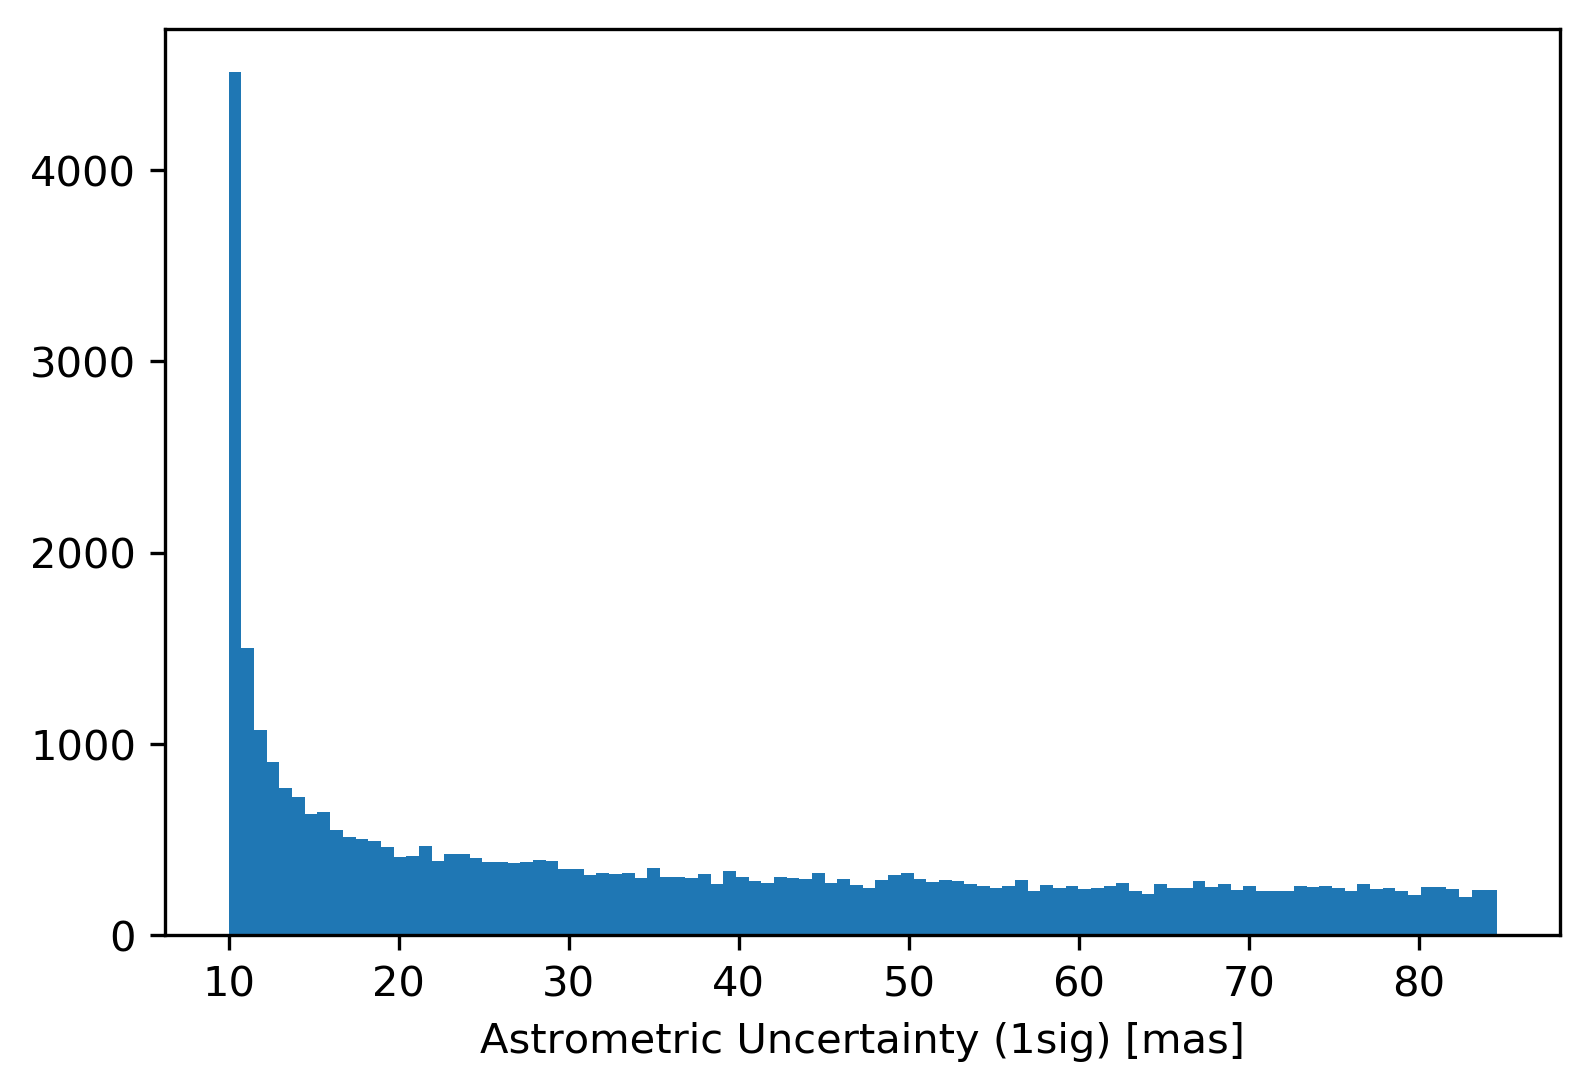

In [266]:
plt.figure(dpi=300)
plt.hist(FDFiltered['AstrometricSigma(mas)'], bins=100)
plt.xlabel('Astrometric Uncertainty (1sig) [mas]')
plt.show()

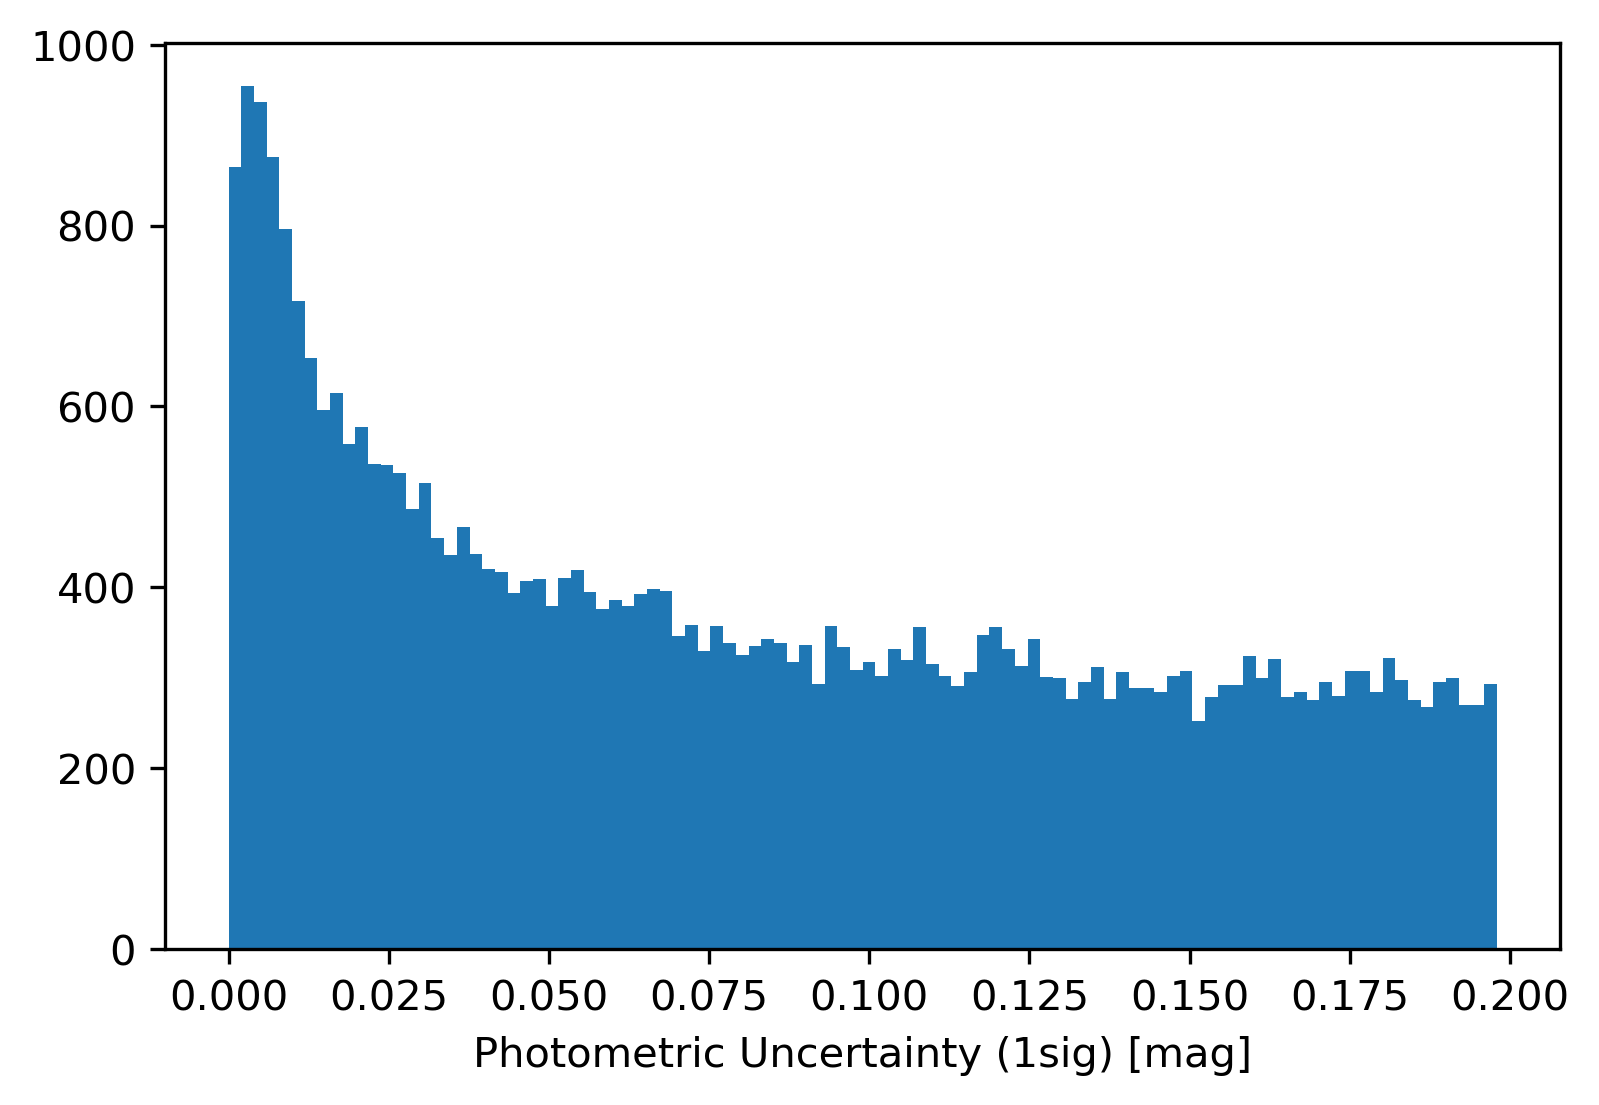

In [267]:
plt.figure(dpi=300)
plt.hist(FDFiltered['PhotometricSigma(mag)'], bins=100)
plt.xlabel('Photometric Uncertainty (1sig) [mag]')
plt.show()

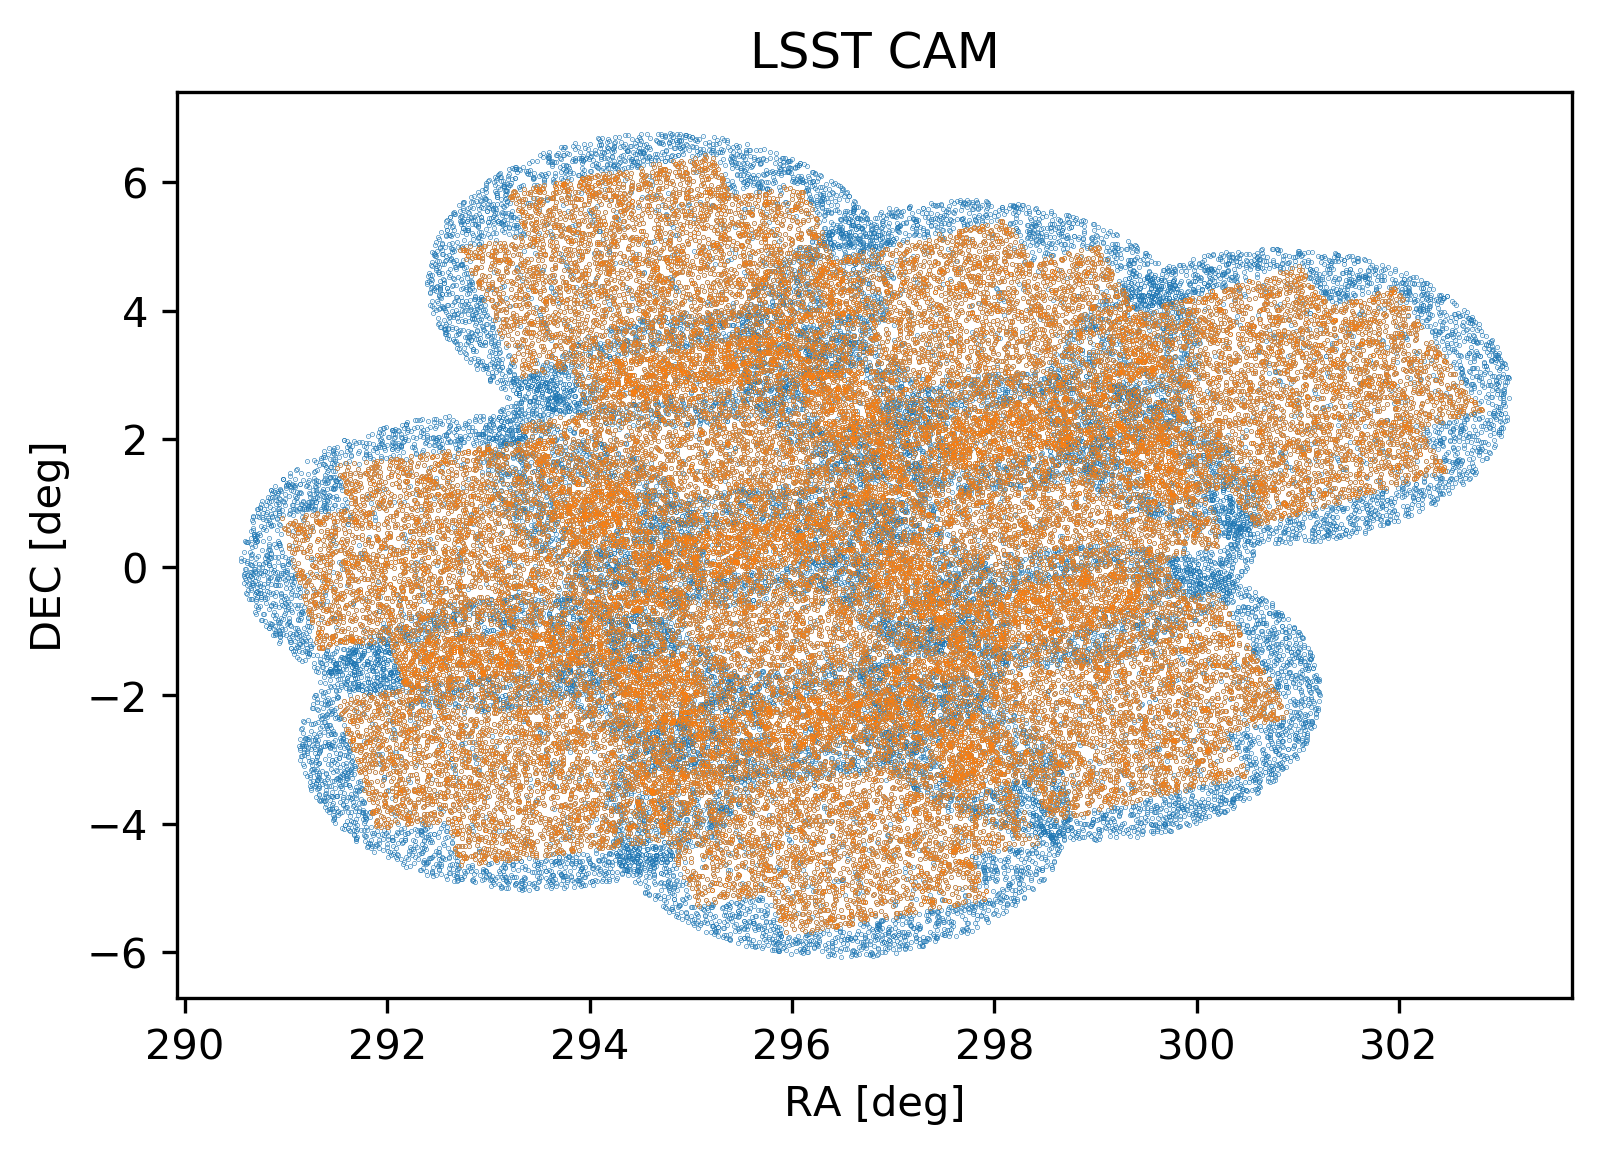

In [226]:
raName='AstRA(deg)'
decName='AstDec(deg)'

plt.figure(dpi=300)
plt.scatter(FDdf[raName],FDdf[decName],s=0.02)
plt.scatter(FDFiltered[raName],FDFiltered[decName],s=0.02)
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')
plt.title('LSST CAM')
plt.show()

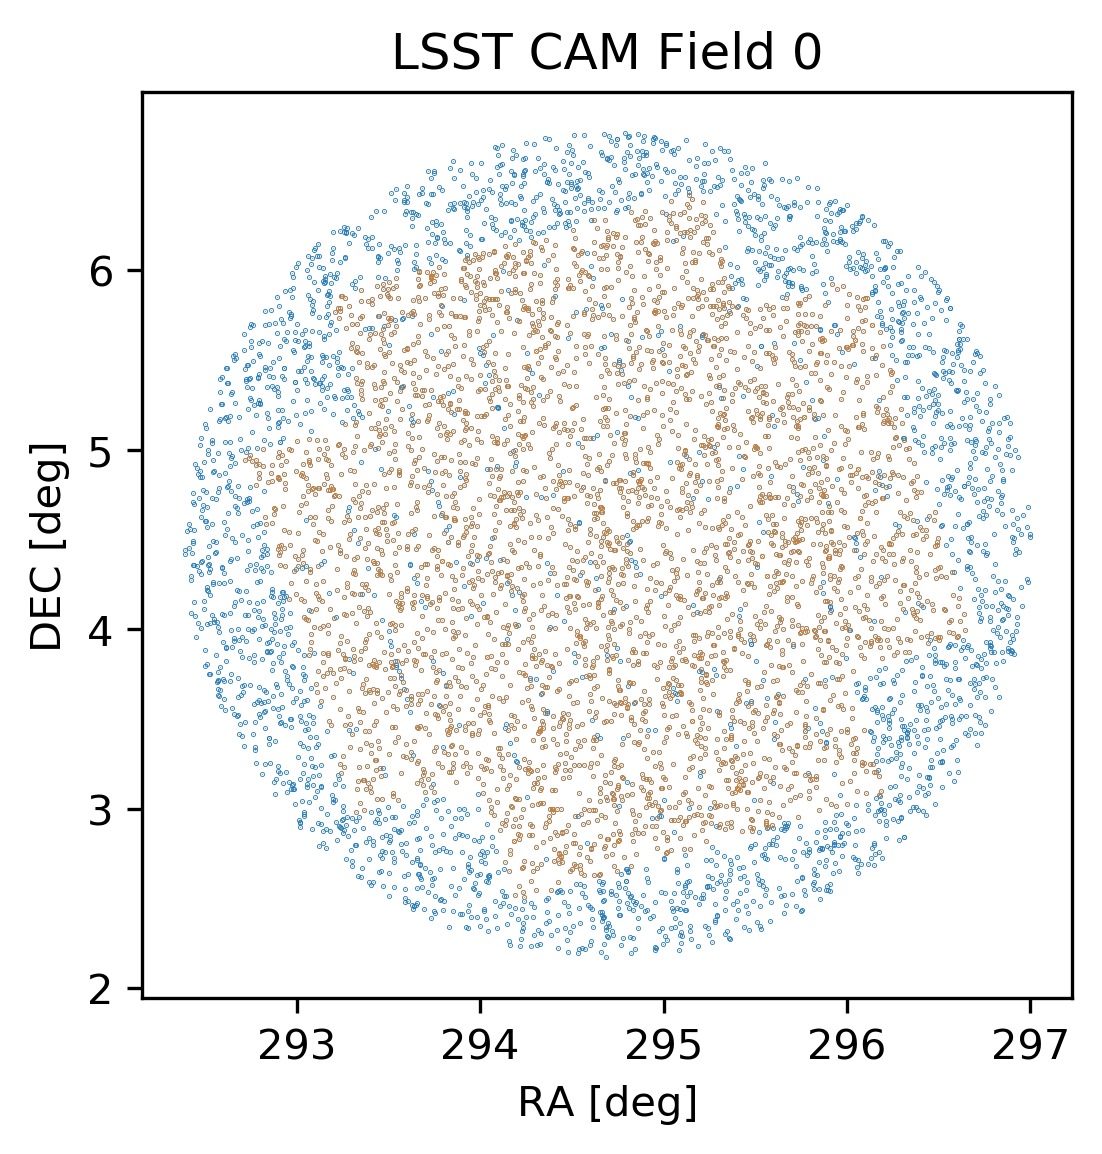

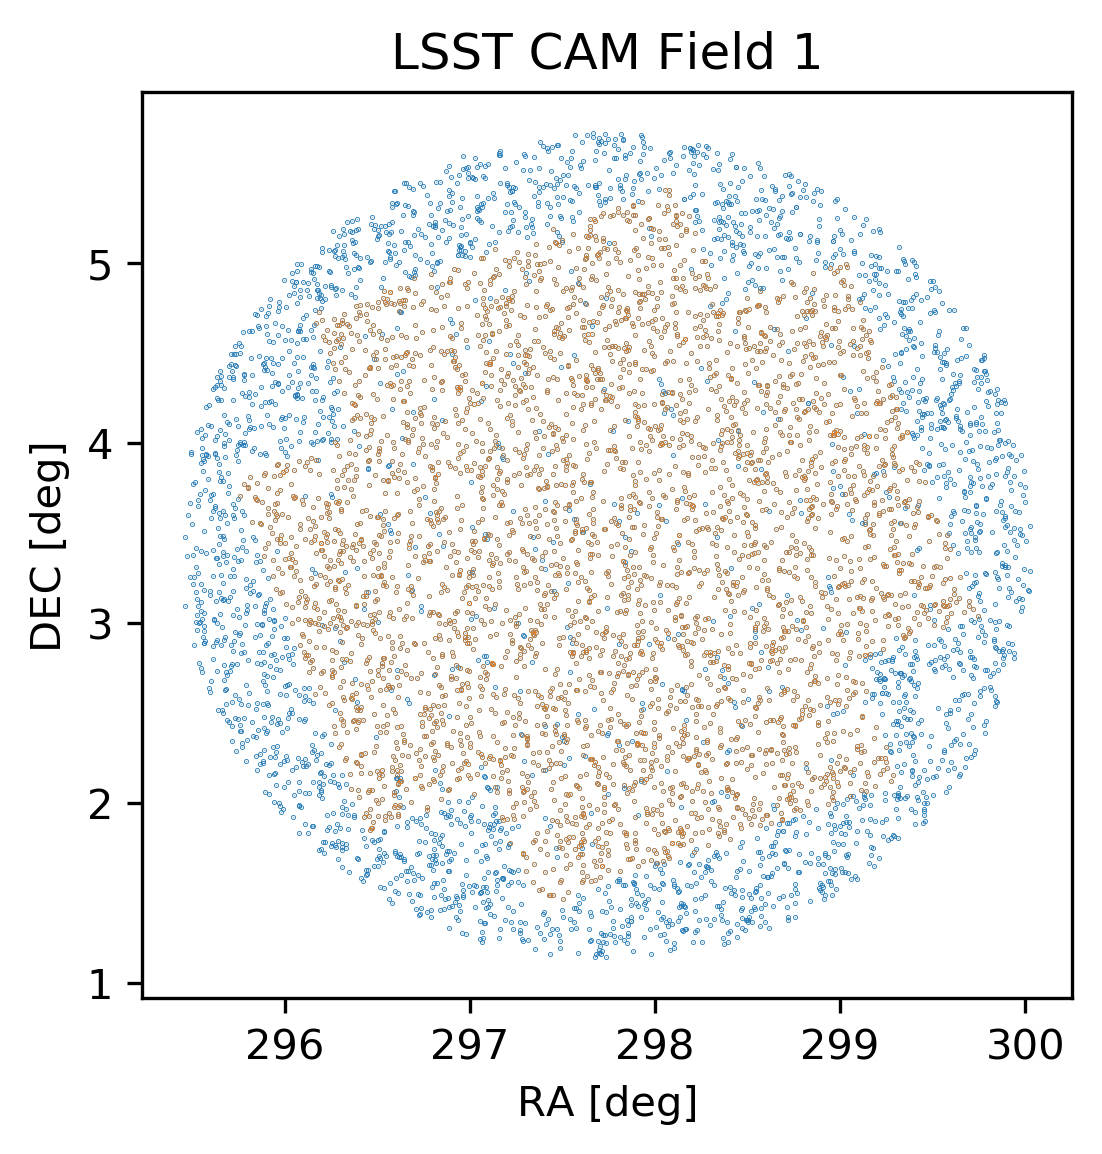

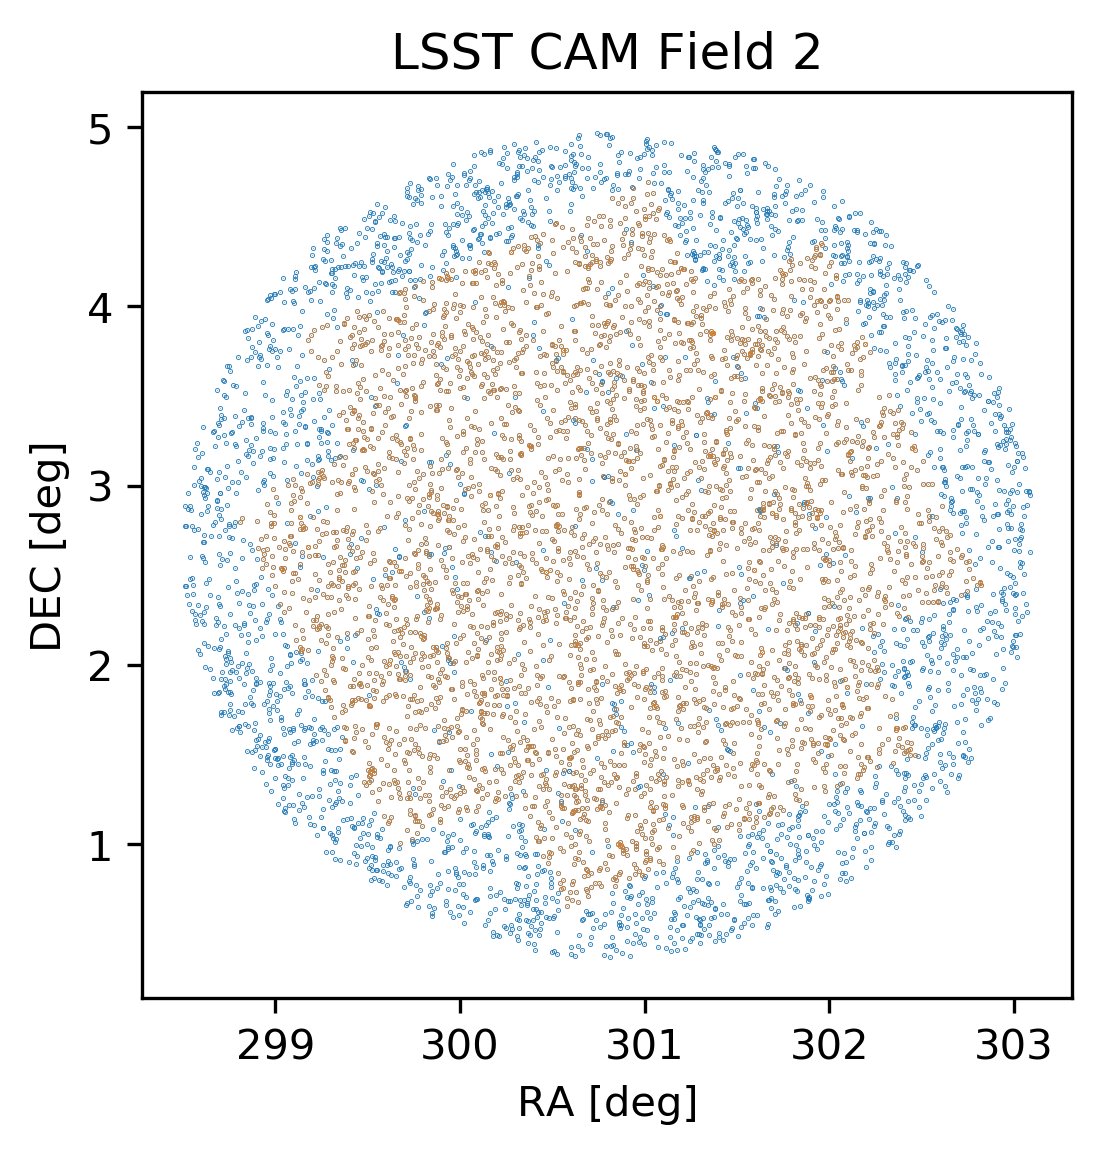

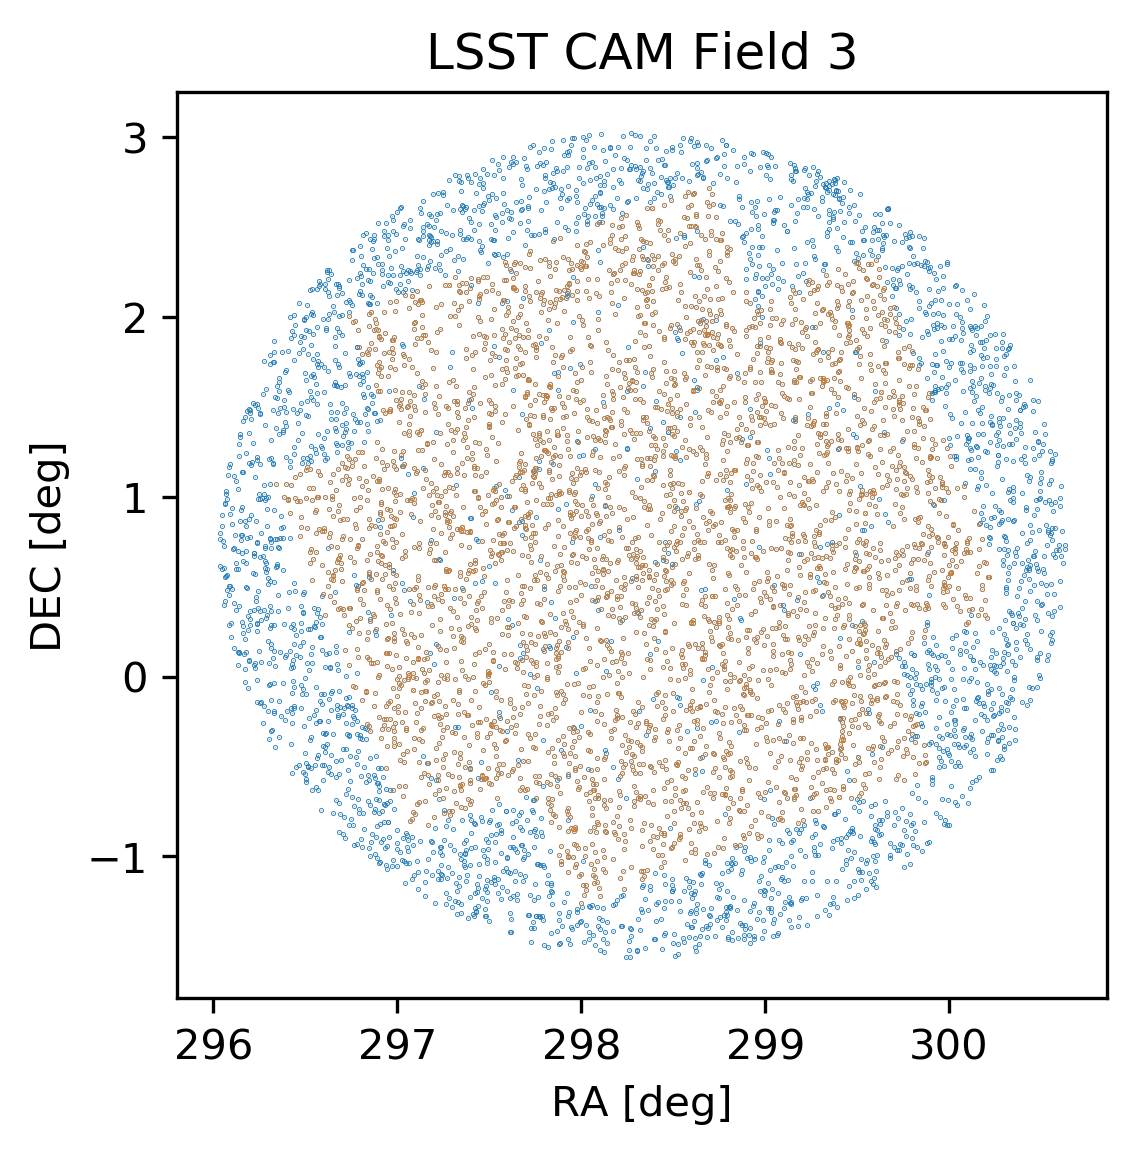

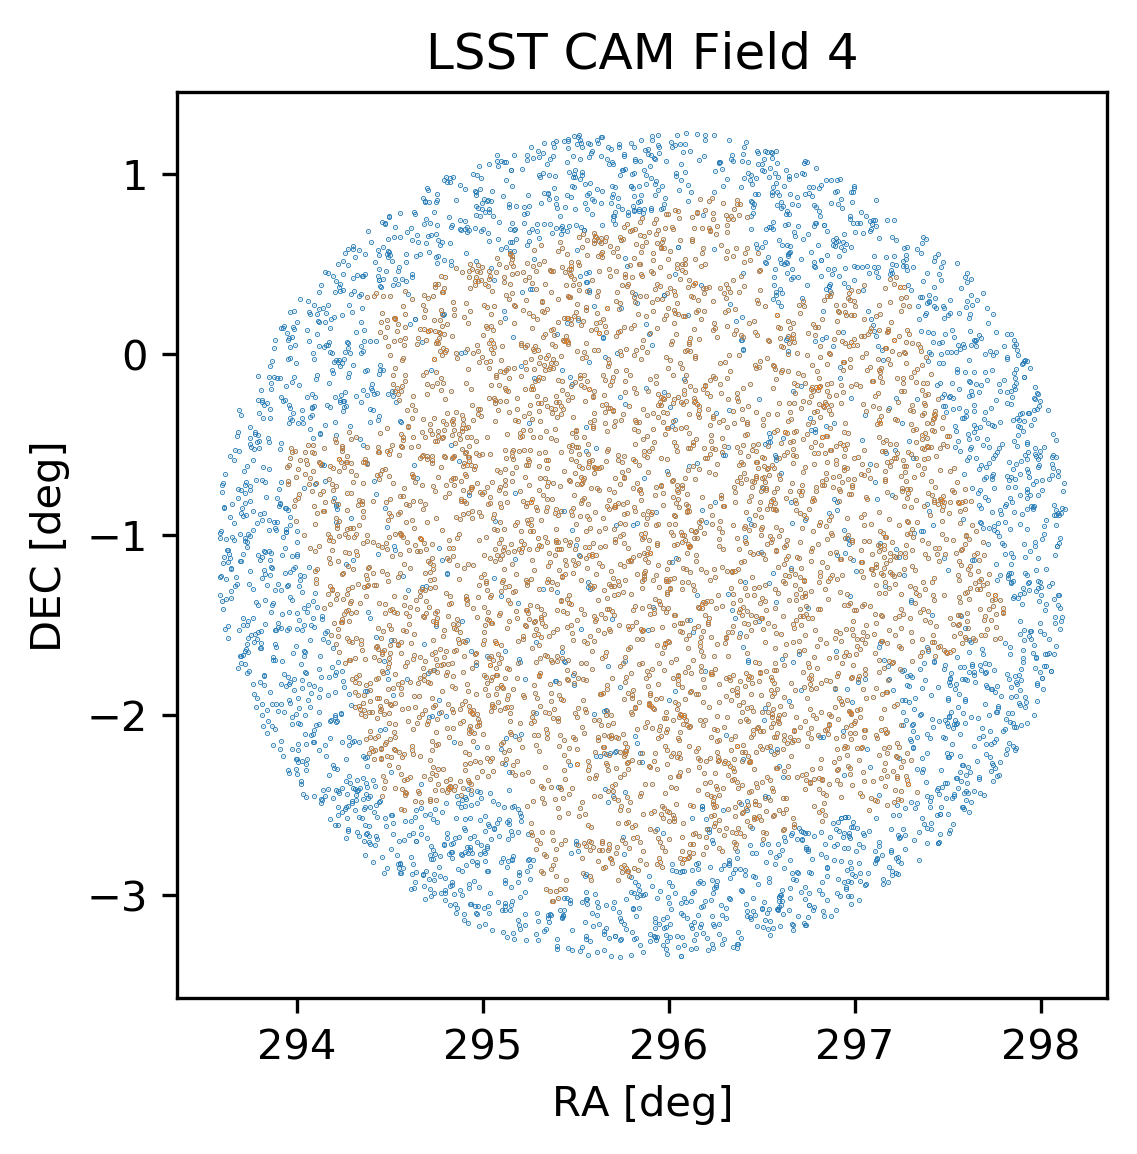

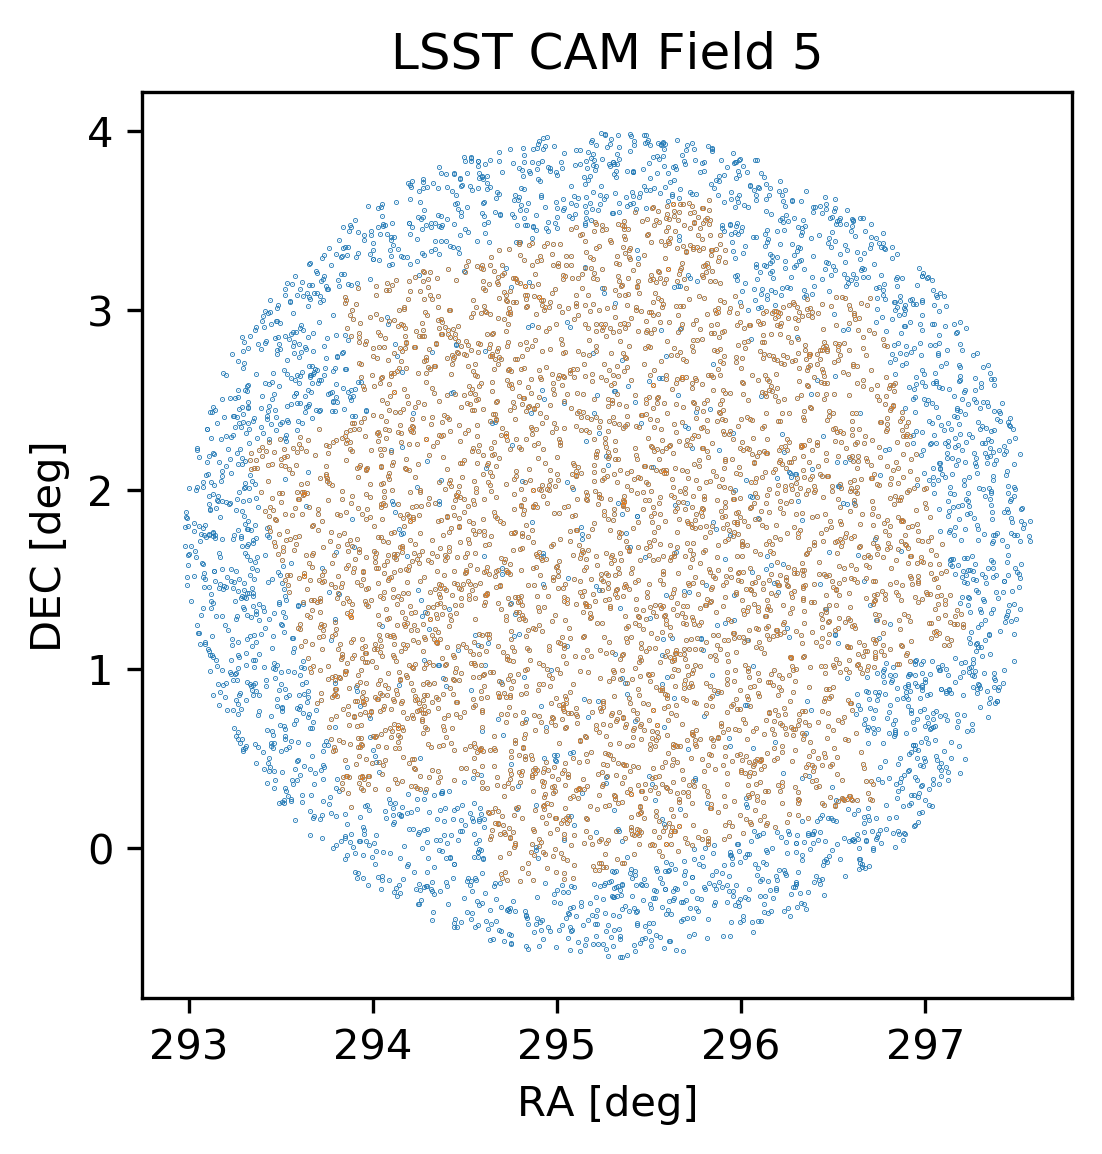

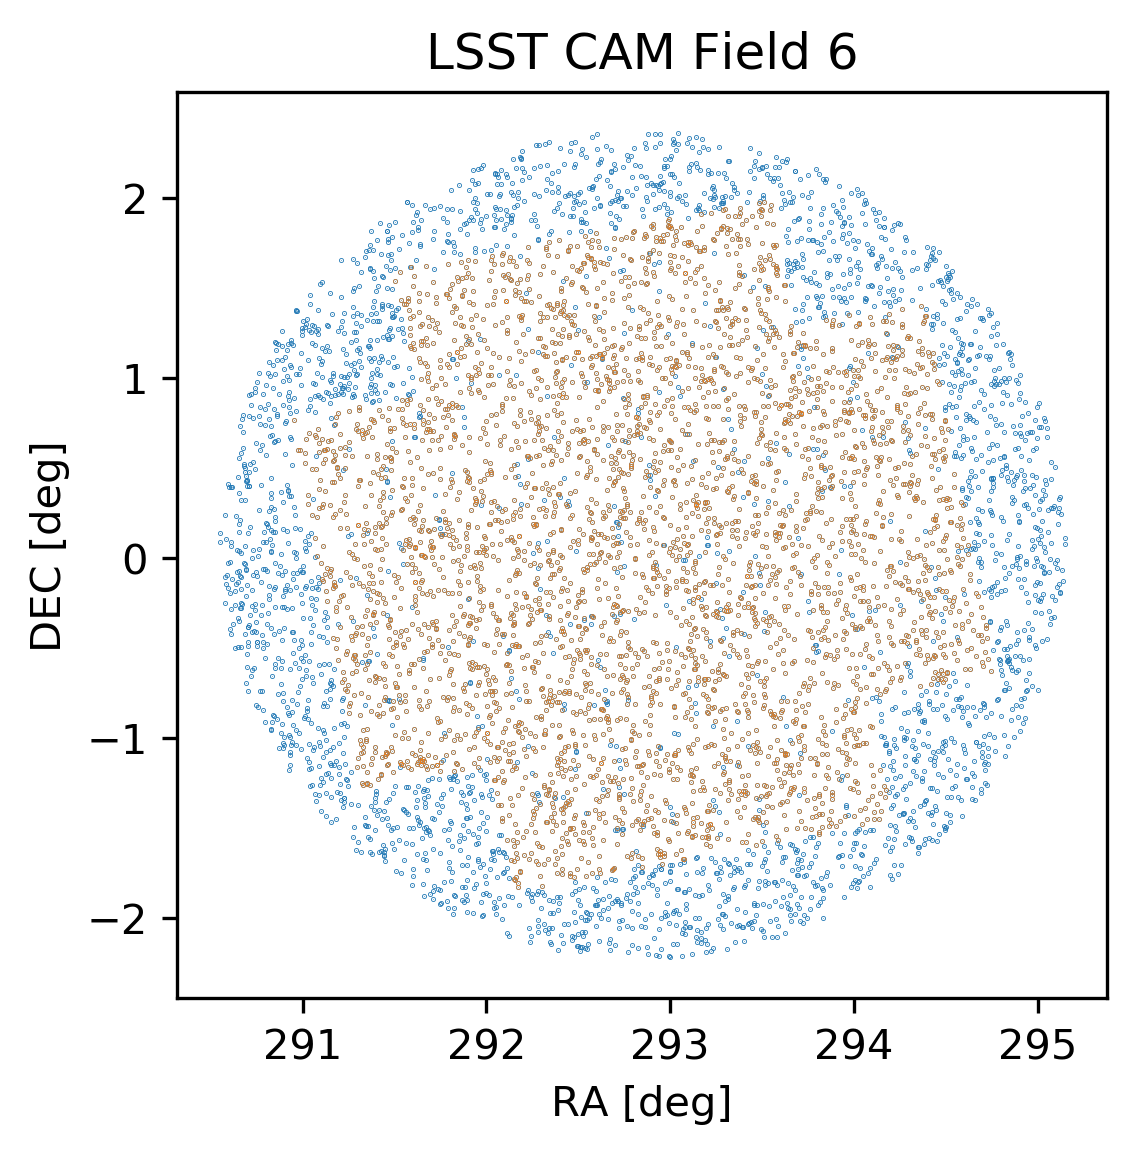

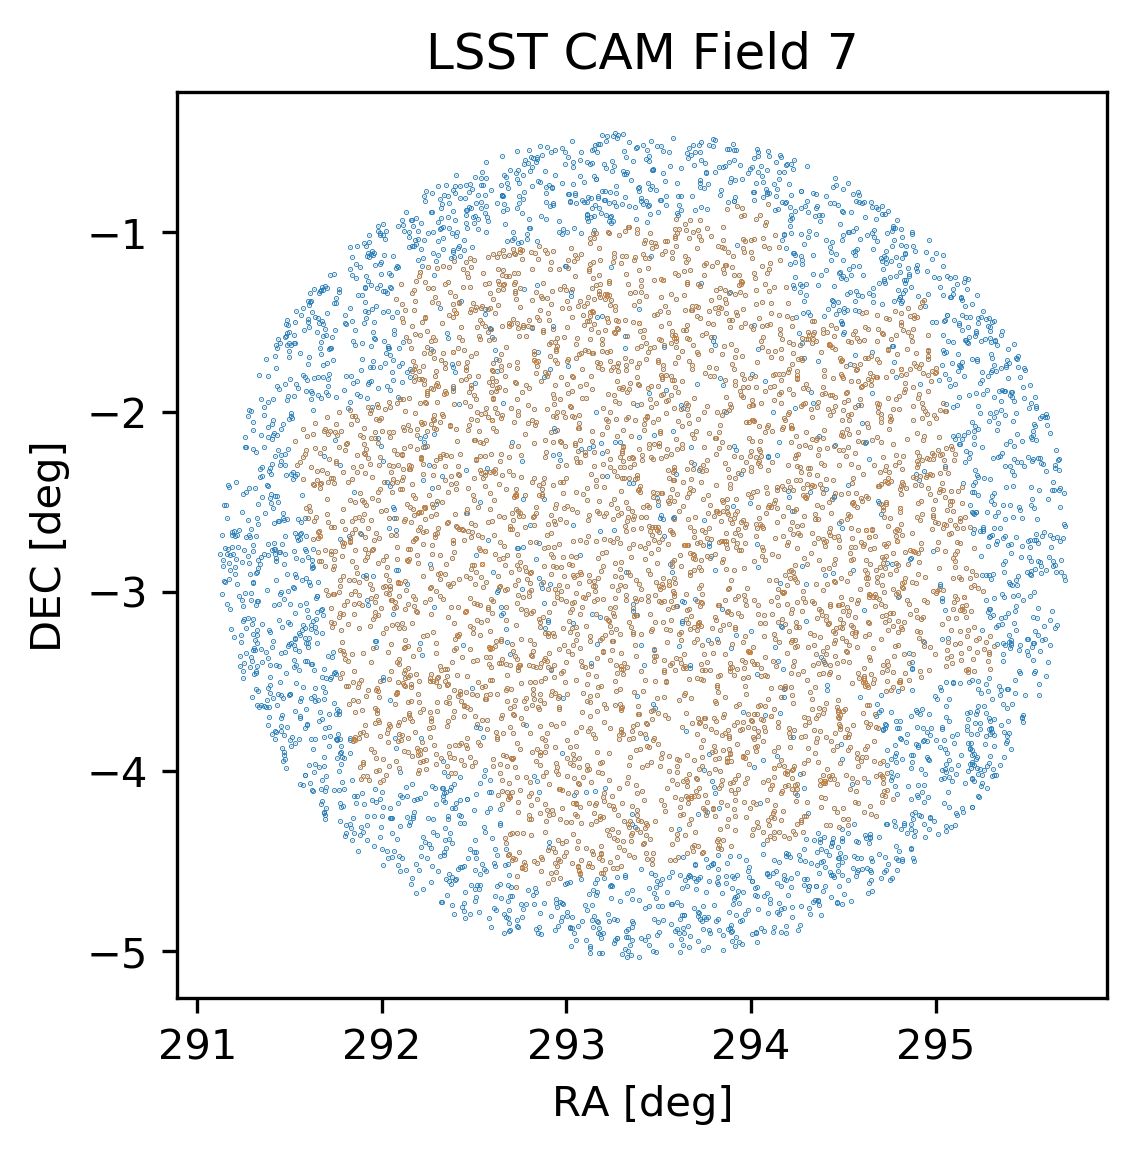

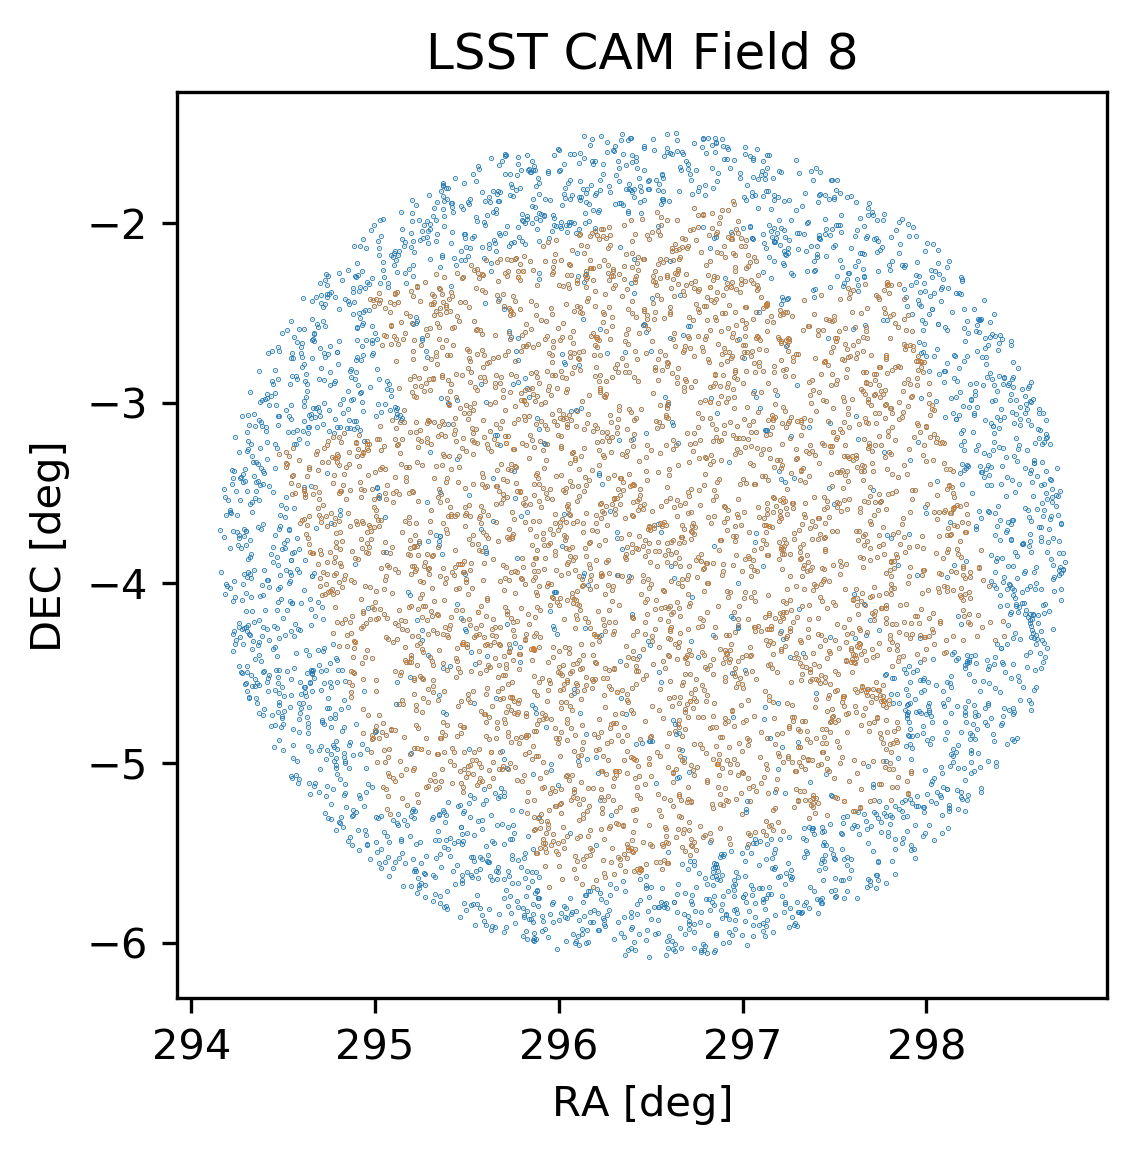

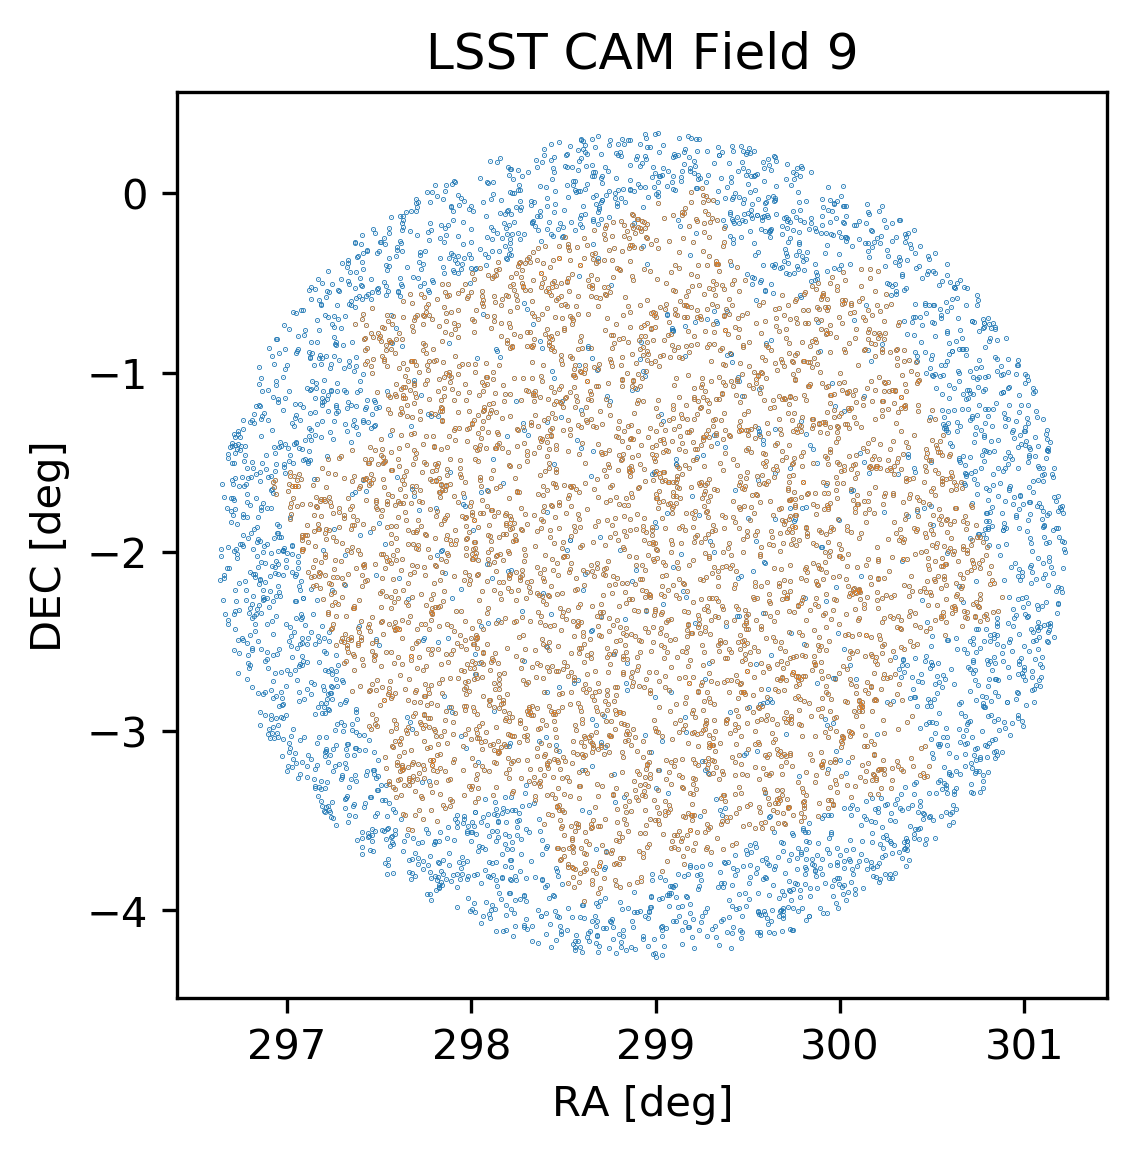

In [240]:
for n in range(10):
    FDF2=FDFiltered[FDFiltered['observationId']==n]
    FDdf2=FDdf[FDdf['observationId']==n]

    raName='AstRA(deg)'
    decName='AstDec(deg)'

    plt.figure(dpi=300, figsize=(4,4))
    plt.scatter(FDdf2[raName],FDdf2[decName],s=0.04)
    plt.scatter(FDF2[raName],FDF2[decName],s=0.02)
    plt.xlabel('RA [deg]')
    plt.ylabel('DEC [deg]')
    plt.title('LSST CAM Field '+str(n))
    plt.show()

In [348]:
NSdf, nNSlist=createRandomNoise(LSSTdf)

nNS/deg^2>nLim: 2818.235294117647 1000
seeing: 0.09081766145149923
nNS/deg^2>nLim: 2818.235294117647 1000
seeing: 0.09081766145149923
nNS/deg^2>nLim: 2818.235294117647 1000
seeing: 0.09081766145149923
nNS/deg^2>nLim: 2818.235294117647 1000
seeing: 0.09081766145149923


KeyboardInterrupt: 

In [303]:
NSFiltered=cameraFootprintFilter(NSdf,LSSTdf,raname='fieldRA',decname='fieldDec',obsIdname='observationId', 
                   obsepochname='observationStartMJD',rotskyname='rotSkyPos')

In [ ]:
# Plot the seeing distribution
plt.figure(dpi=150)
plt.title('LSST Opsim Seeing Distribution')
LSSTdf.seeingFwhm500.hist(bins=100)
plt.grid(False)
plt.xlabel('seeing FWHM [arcsec]')
plt.show()

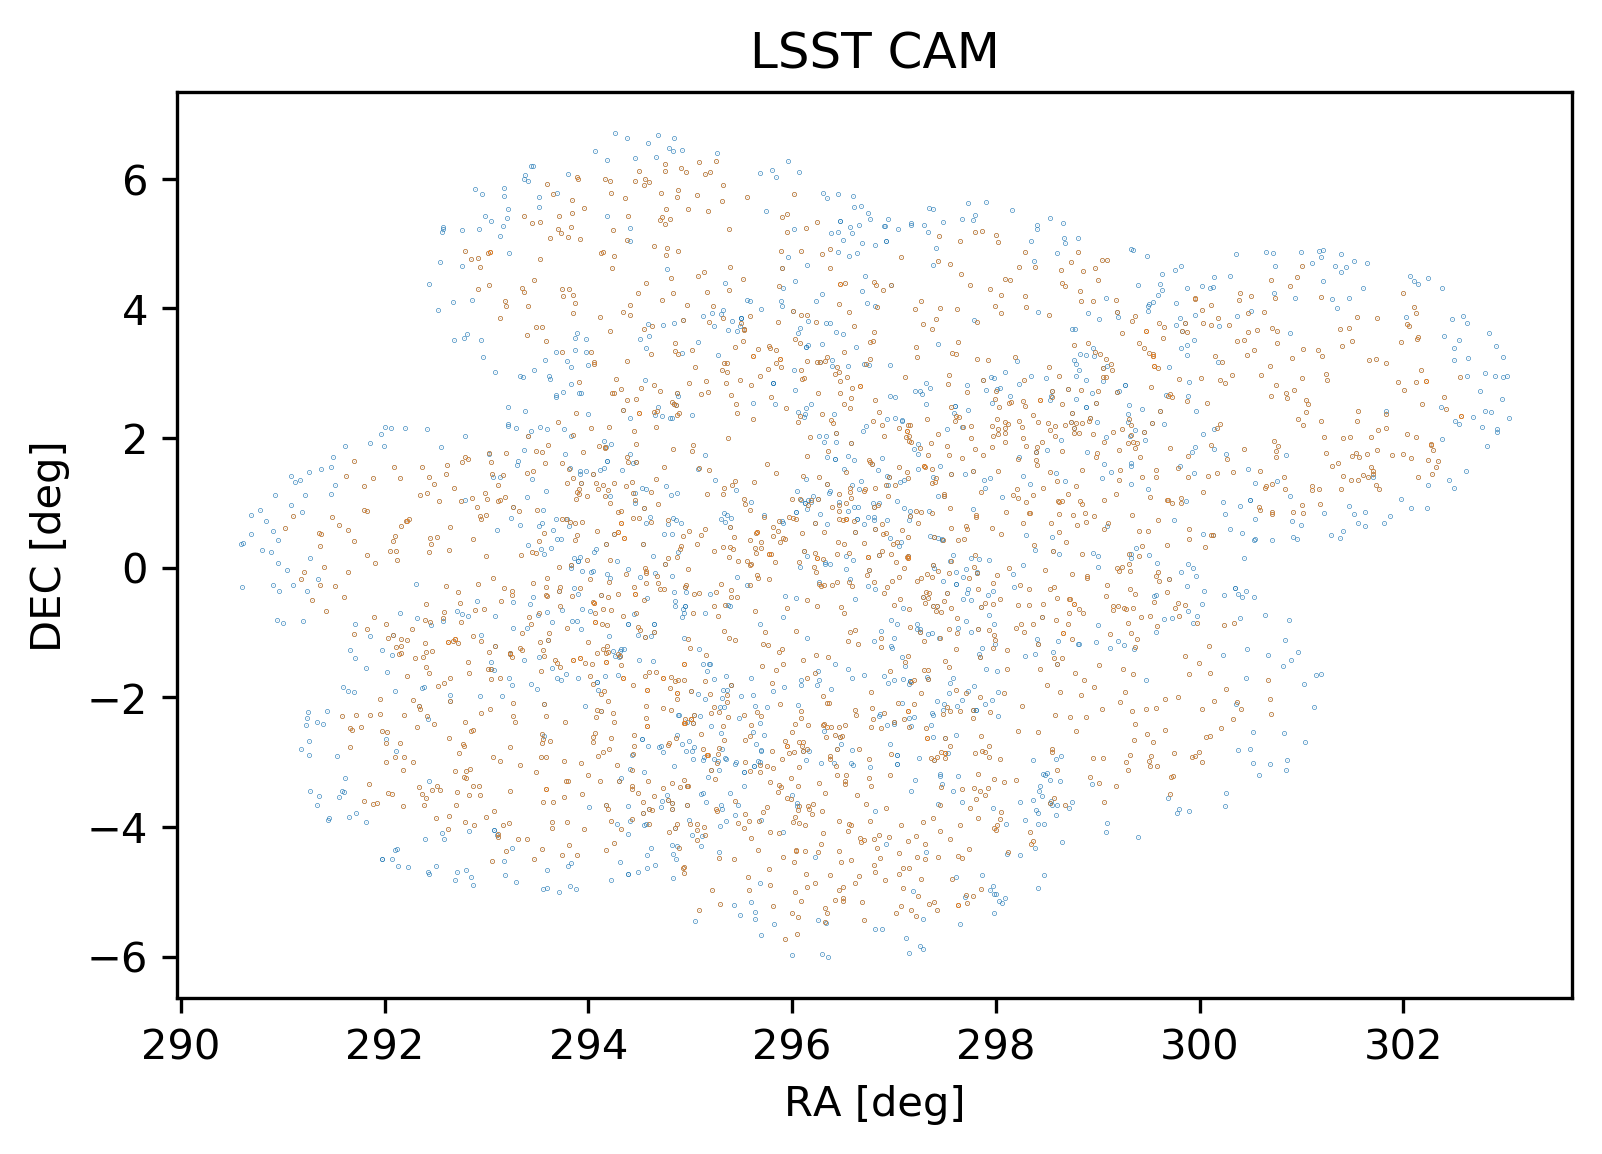

In [304]:
plt.figure(dpi=300)
plt.scatter(NSdf[raName],NSdf[decName],s=0.02)
plt.scatter(NSFiltered[raName],NSFiltered[decName],s=0.02)
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')
plt.title('LSST CAM')
plt.show()

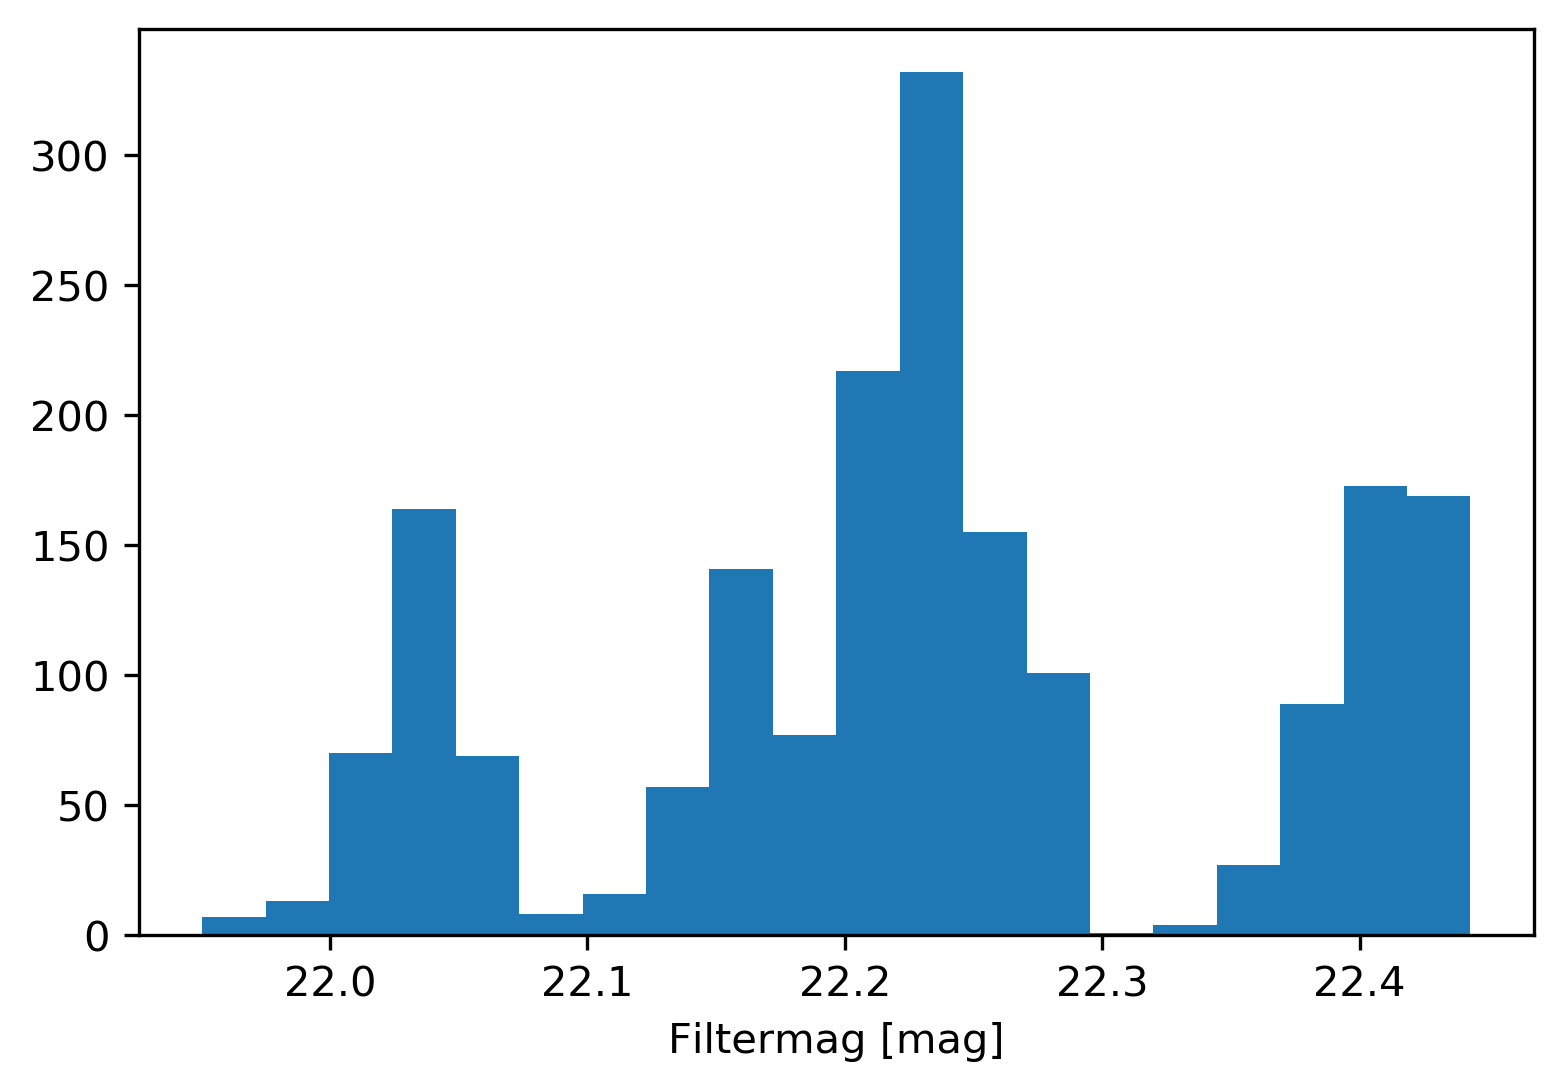

In [307]:
plt.figure(dpi=300)
plt.hist(NSFiltered['Filtermag'], bins=20)
plt.xlabel('Filtermag [mag]')
plt.show()

In [312]:
LSSTdf['fiveSigmaDepth']

0    22.045286
1    22.060010
2    22.166262
3    22.240384
4    22.284123
5    22.215072
6    22.251564
7    22.409917
8    22.443228
9    22.254420
Name: fiveSigmaDepth, dtype: float64

Now import DECam HiTS Data and compare the Difference Image Artifact (DIA) source distirbutions. The real/bogus ratio is roughly 0.25 (Bellm & Rawls, 2020, private communication).

In [42]:
df_flux=pd.read_csv('cw_2020_05_diaSrcFluxes.csv')
df_flux.drop(df_flux.columns[0],axis=1,inplace=True)
df_flux.dropna(inplace=True)

In [43]:
df_flux.sort_values(by=['diaSourceId'],inplace=True)

In [44]:
df_flux.drop_duplicates(['diaSourceId'],inplace=True)

In [45]:
# drop every DIA source that with a flux less than 5x the flux error (5-sigma clipping)
df_5sig=df_flux[(df_flux['totFlux']>=5*df_flux['totFluxErr'])]

In [46]:
len(df_5sig)

44782

### 5-sigma clipping could separate small SNR DIA sources from likely detections

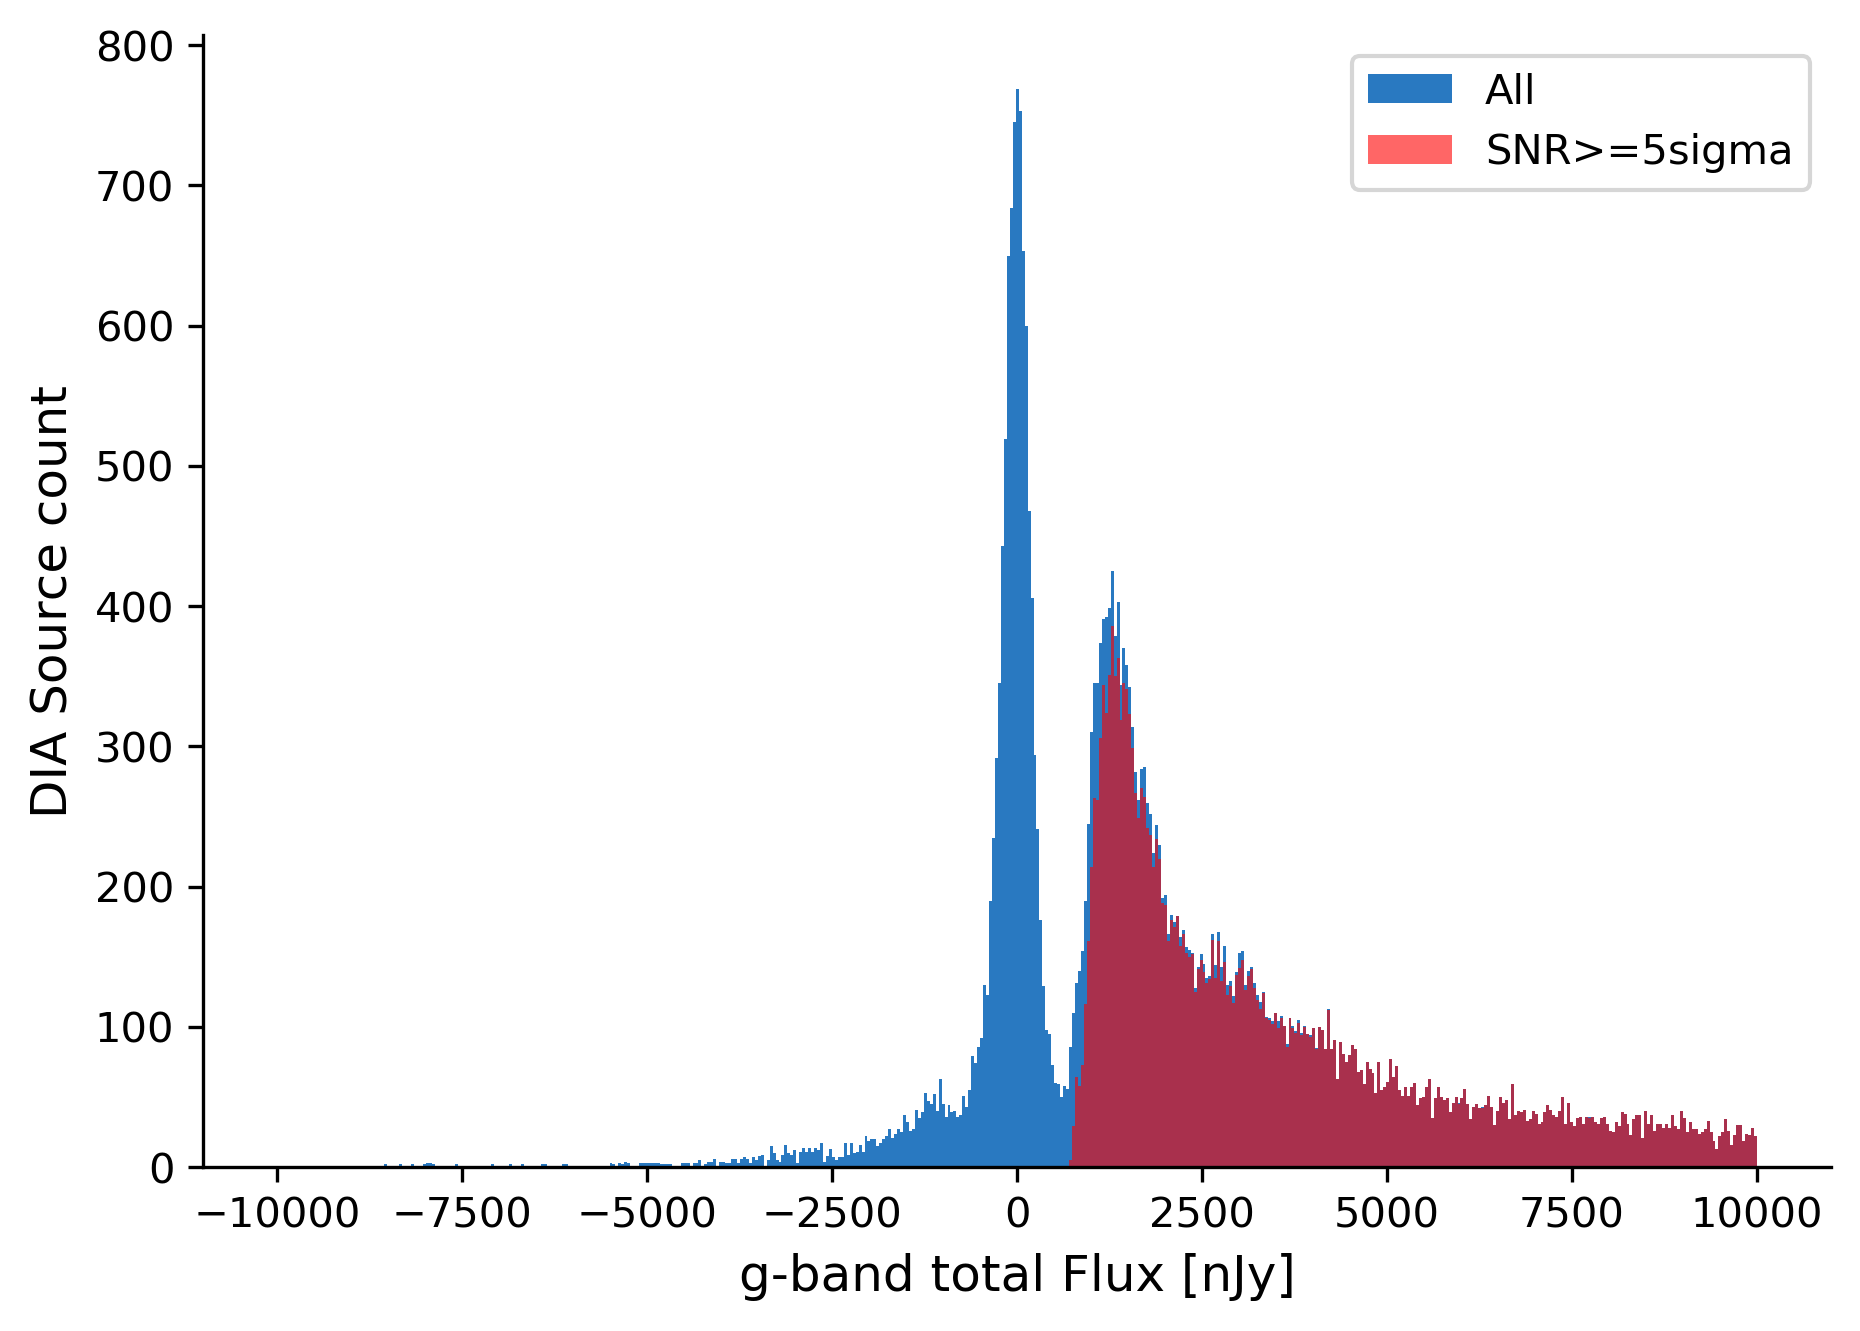

In [47]:
plotHiTSFluxes(df_flux,df_5sig)

### Since we want to model false detections, we will not use forced photometry fluxes and include all DIA Sources (those have already been through a 5sigma filter to be declared DIA Sources)

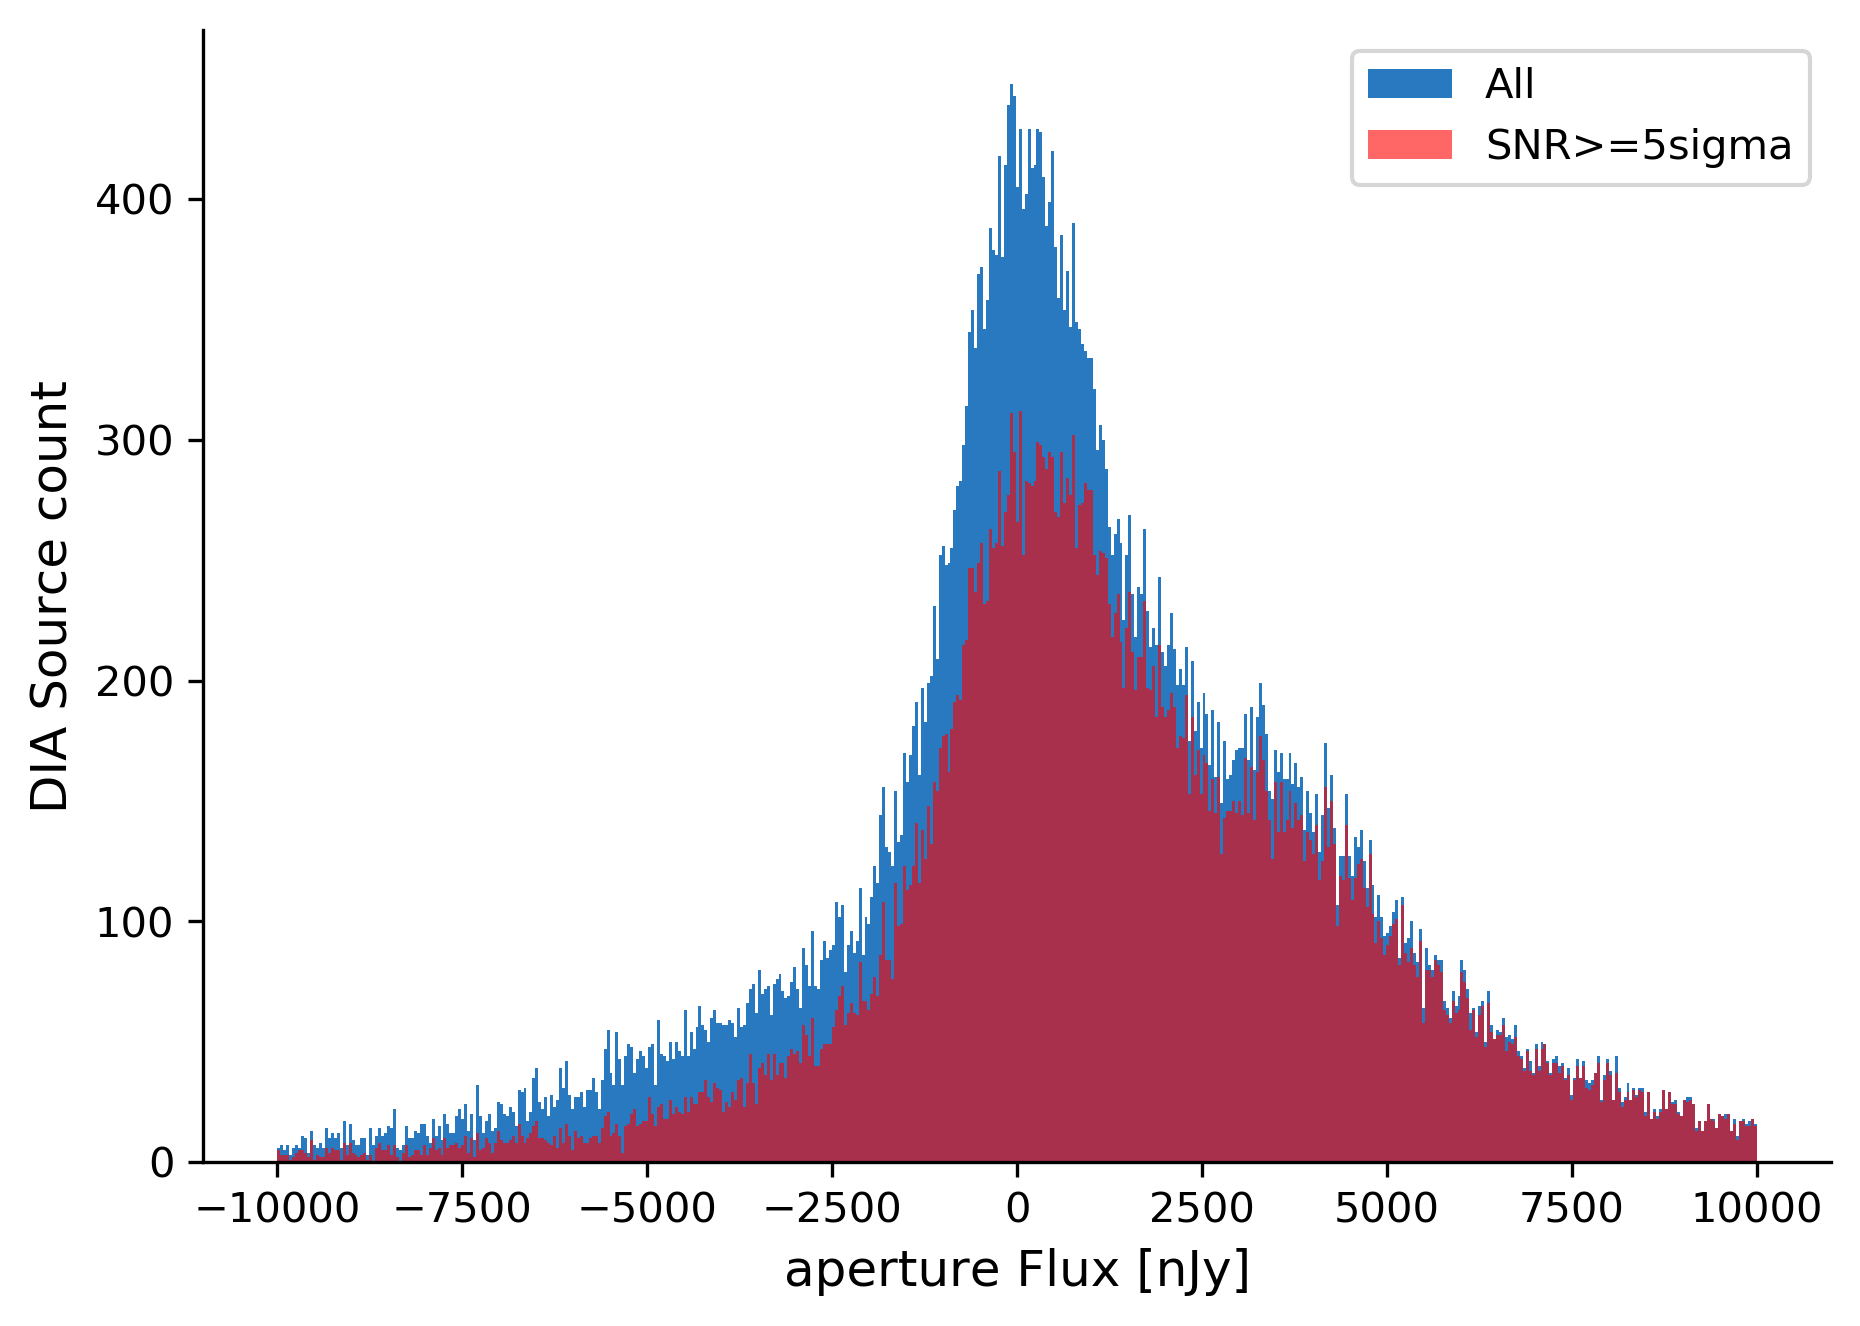

In [48]:
plotHiTSFluxes(df_flux,df_5sig,fluxType='apFlux',xlabel='aperture Flux [nJy]')

### Now let us compare the magnitude distribution of DIA sources (= DIA FD noise) in HiTS and the Veres & Chesley (2017) predictions. 

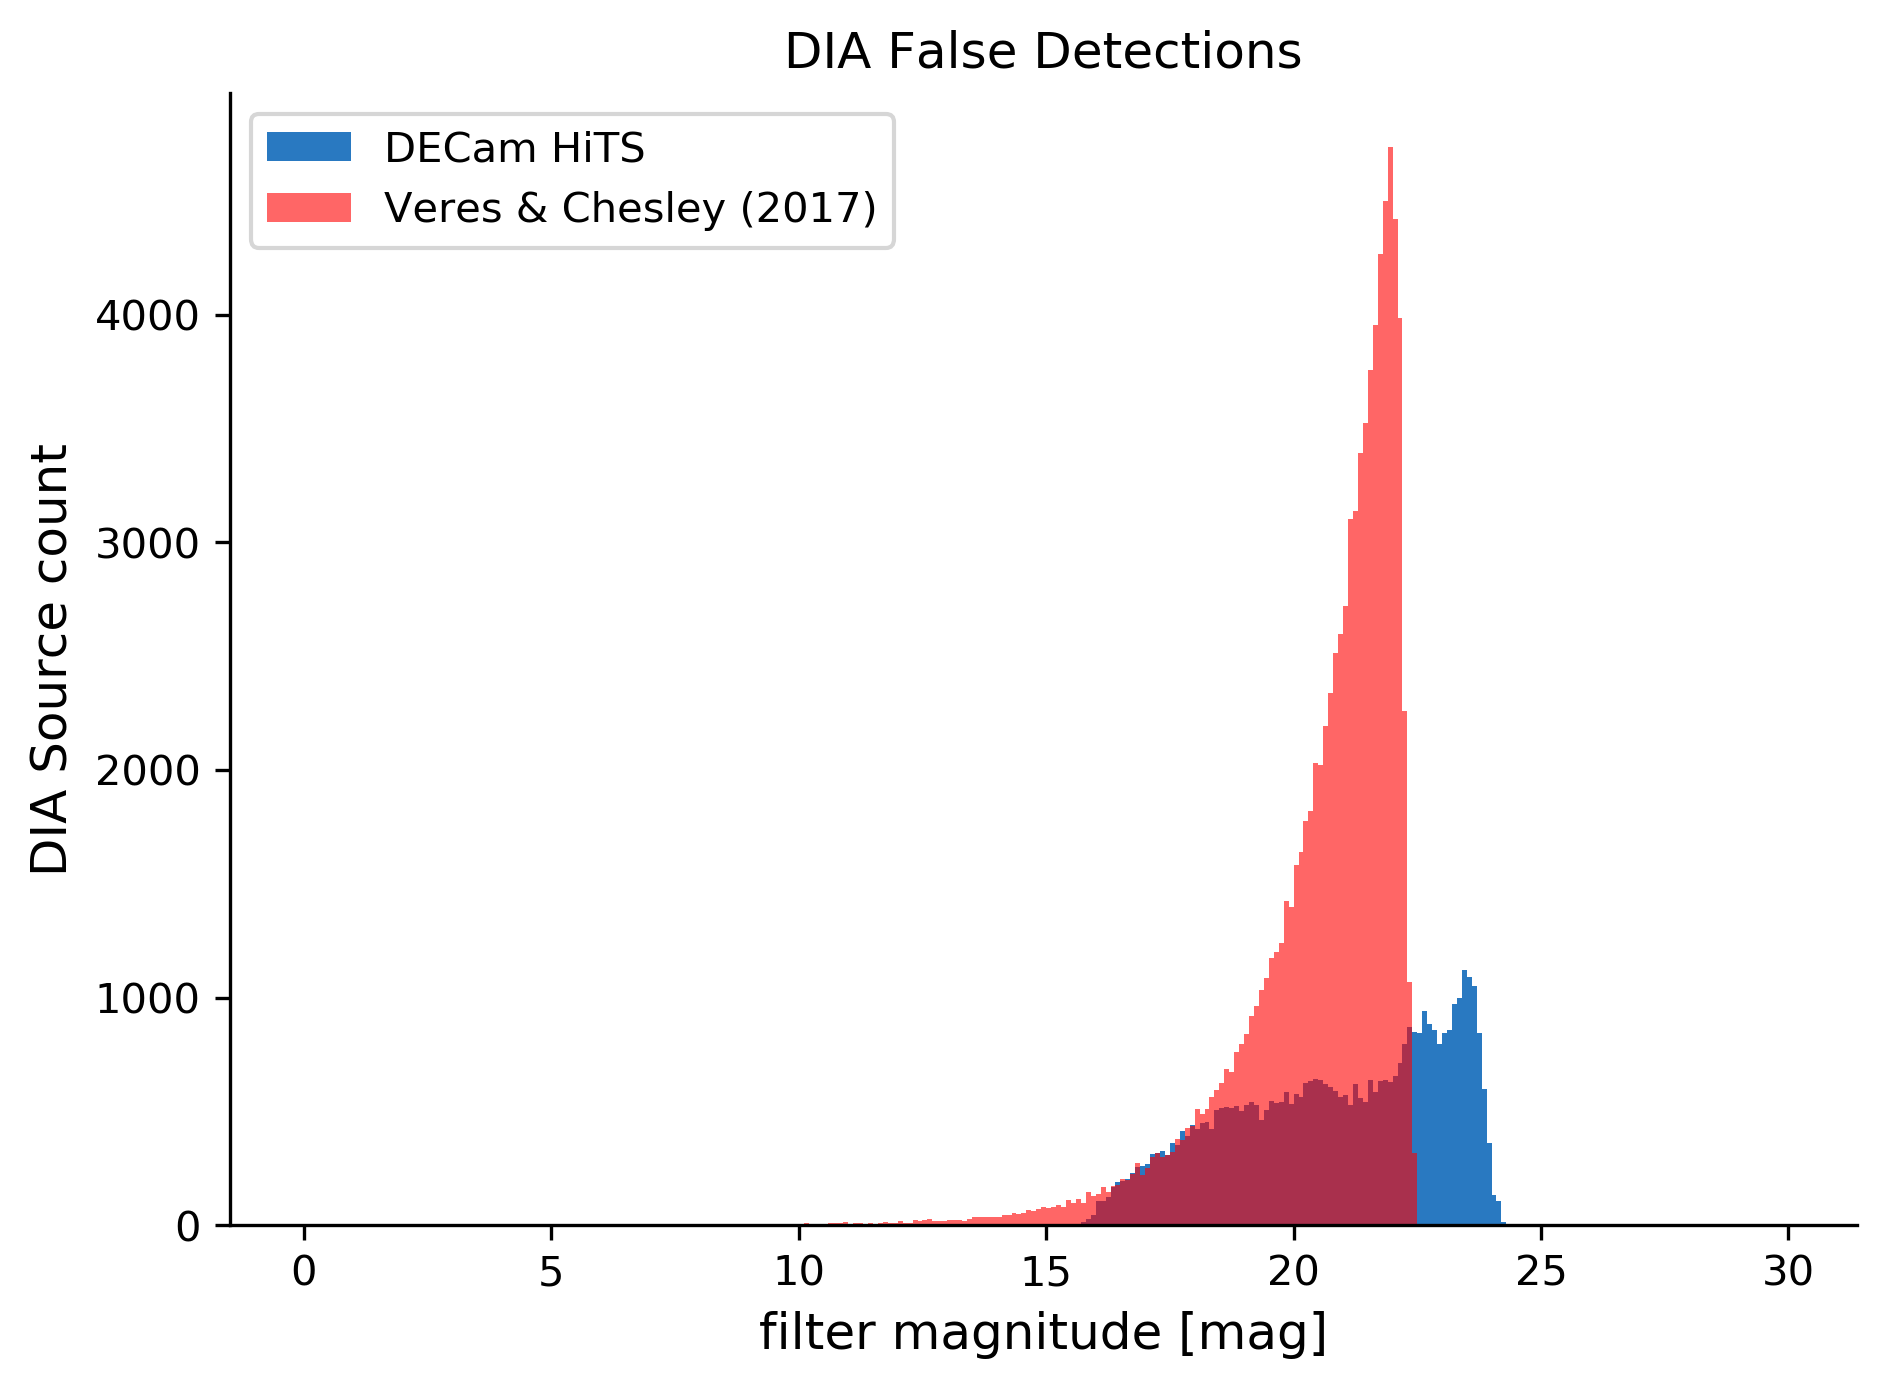

In [51]:
plotNoiseMag(df_5sig,FDdf,fluxType='totFlux', dfVeresMagName='filterMag')

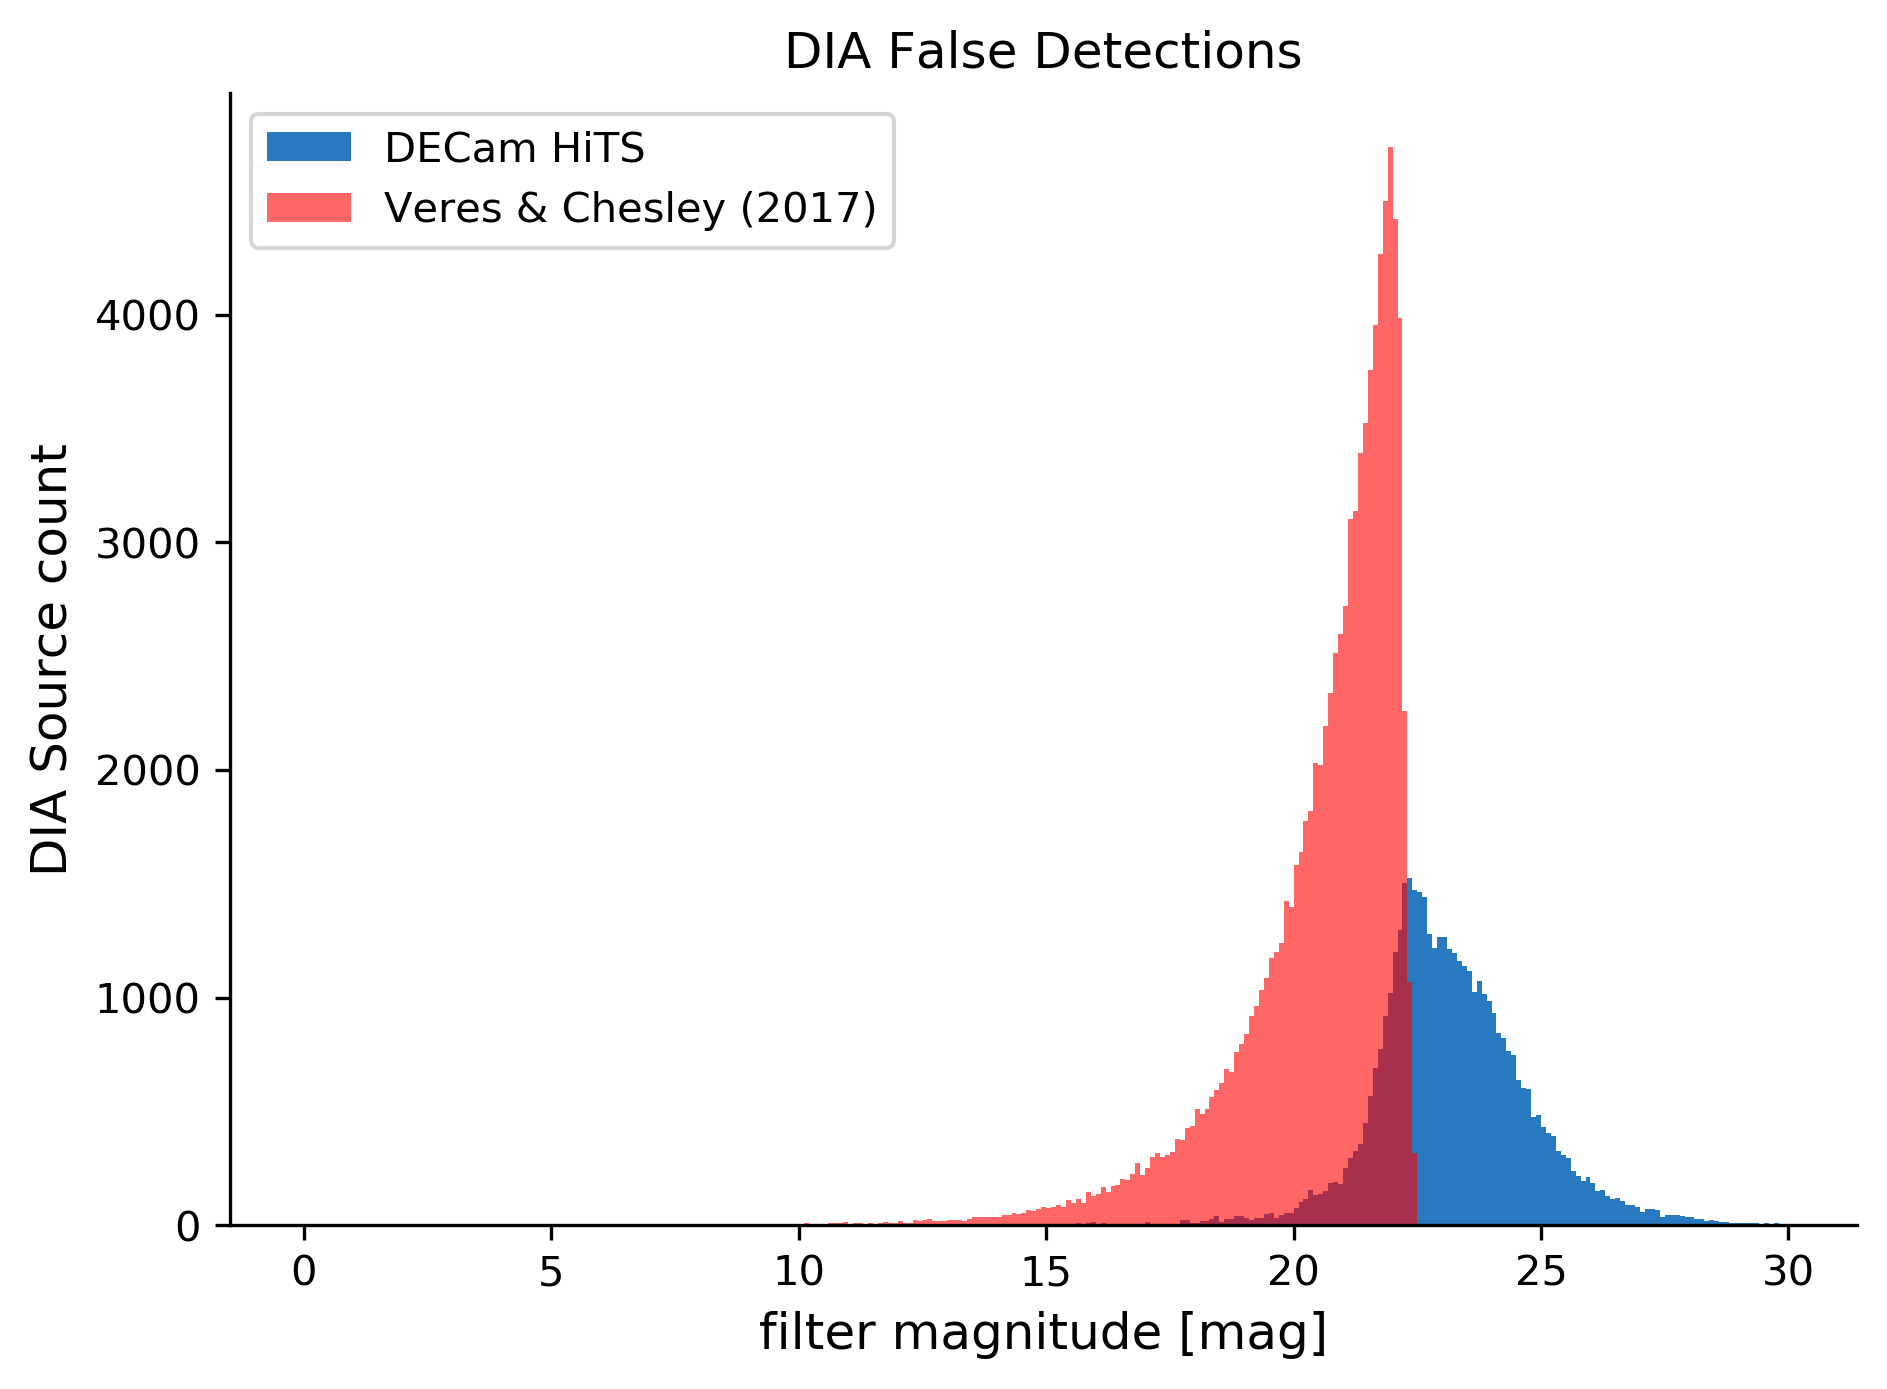

In [52]:
plotNoiseMag(df_5sig,FDdf,fluxType='apFlux', dfVeresMagName='filterMag')

Let us make a kernel density estimatetor for late use.

In [56]:
mags5sig=flux2mag(abs(df_5sig['totFlux'].values*1e-9))
X = np.array([mags5sig])
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(X)
kde.sample()

array([[19.44817164, 17.49626012, 19.75352426, ..., 15.79878378,
        18.5920278 , 21.88736738]])

In [57]:
kde_df=pd.DataFrame(kde.sample()[0],columns=['Filtermag'])

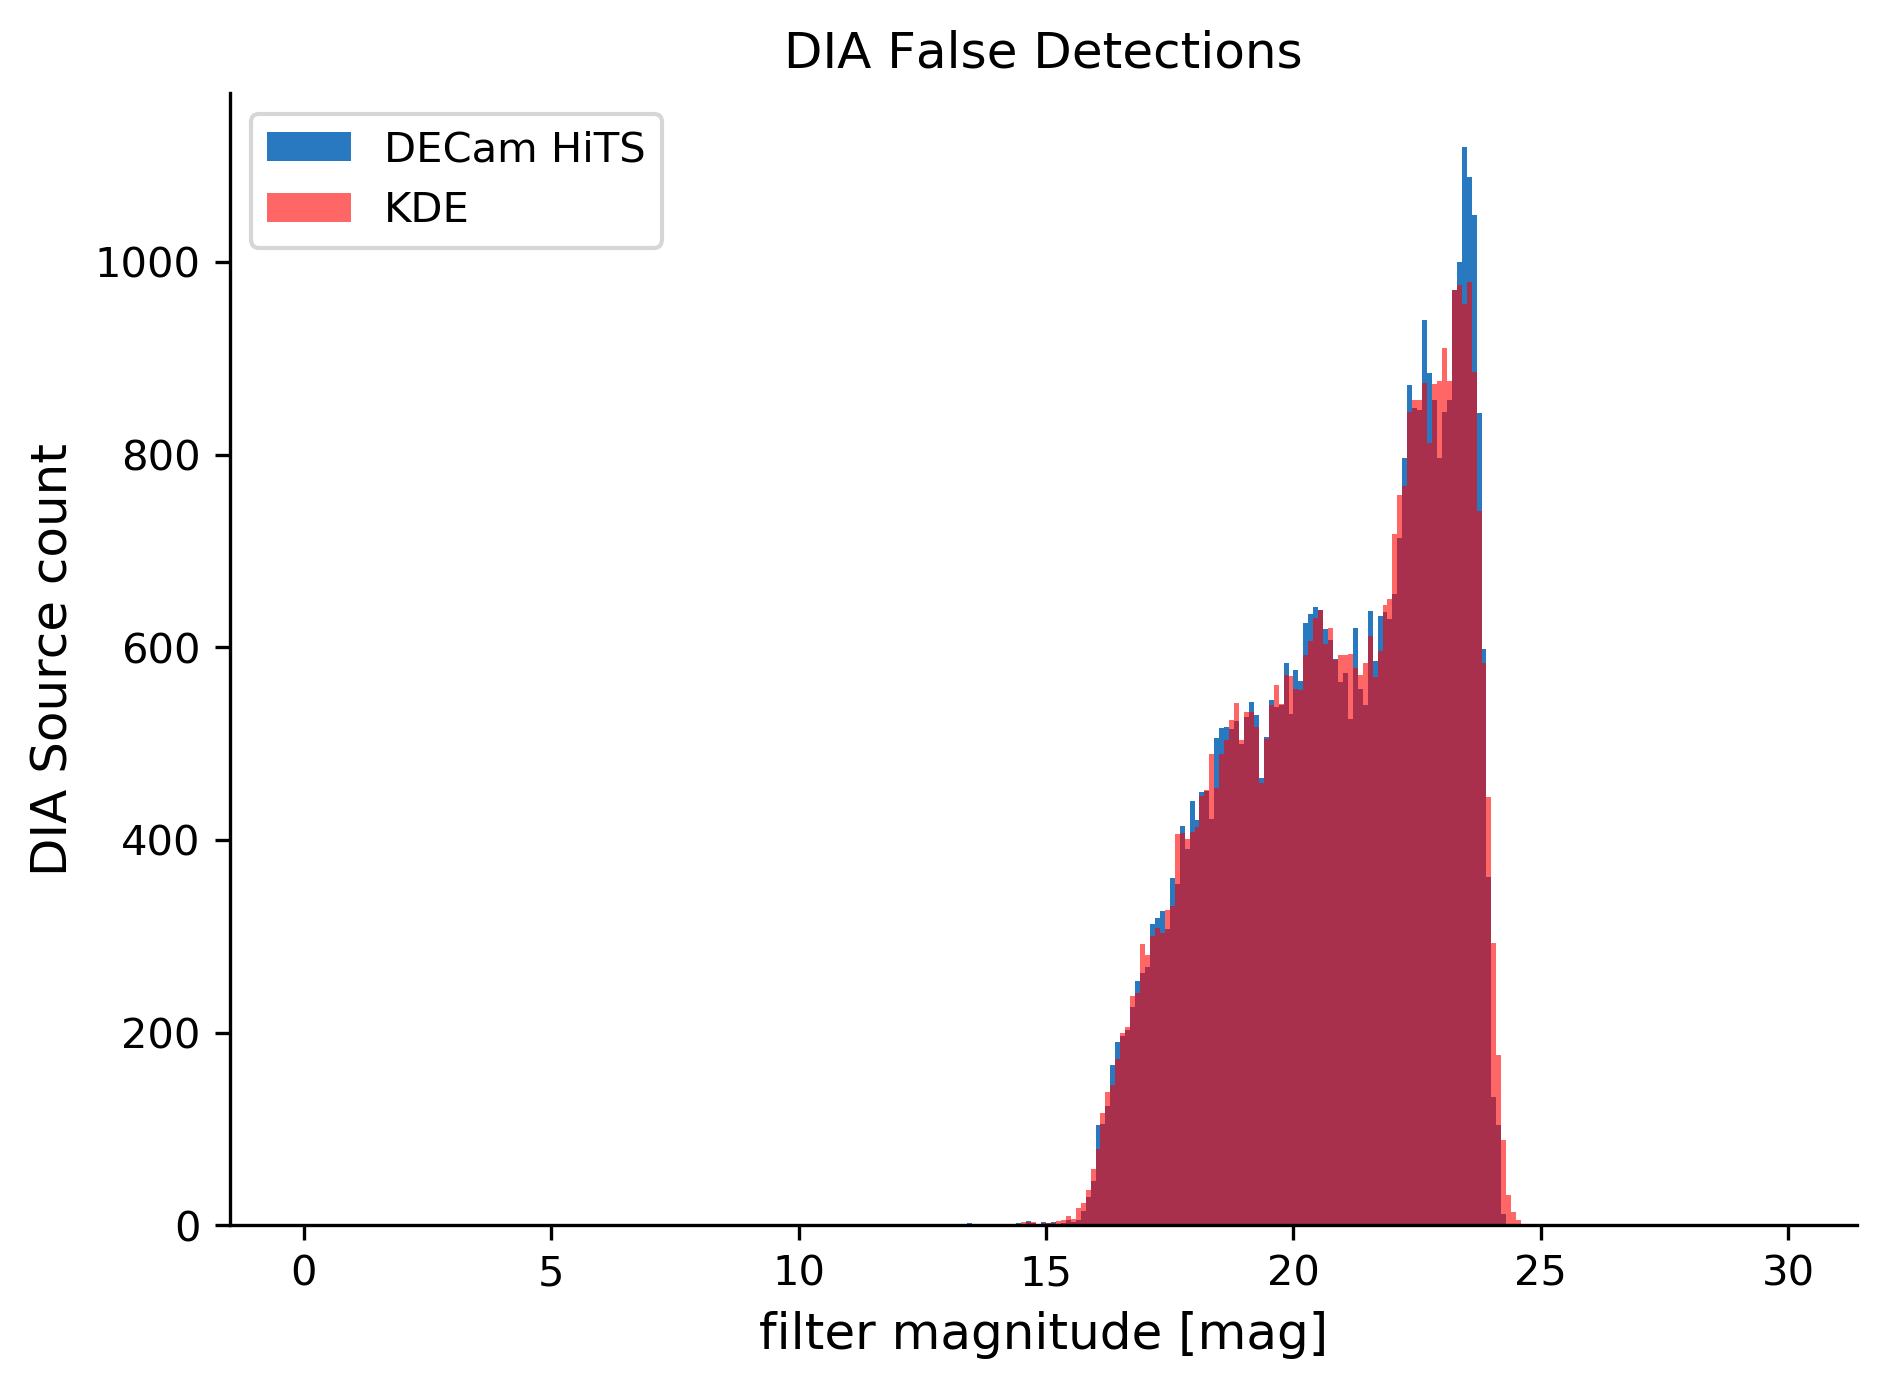

In [59]:
plotNoiseMag(df_5sig,kde_df,label2='KDE',fluxType='totFlux')

### HiTS data shows a correlation between seeing and number of DIA sources. This may be a consequence of template vs observation seeing. We will still use this correlation here just to be self consistent. 

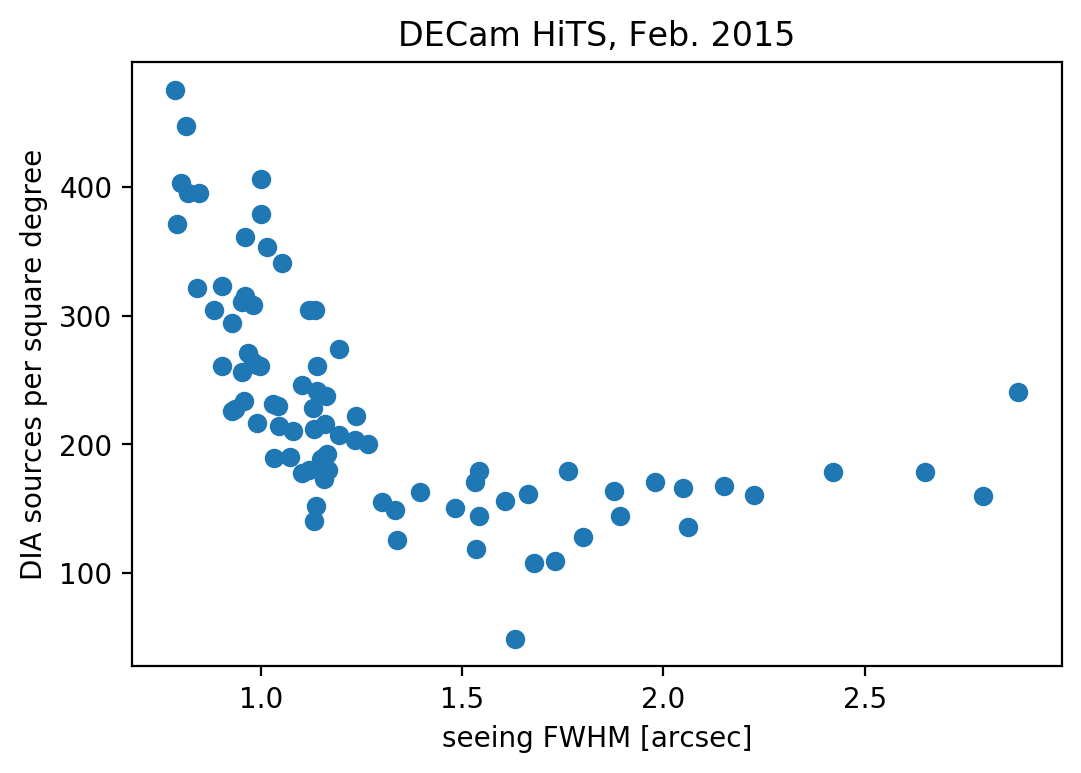

In [60]:
df_dia=nDIAvsSeeing(df_flux)

plt.figure(dpi=200)
plt.xlabel('seeing FWHM [arcsec]')
plt.ylabel('DIA sources per square degree')
plt.title('DECam HiTS, Feb. 2015')
plt.scatter(df_dia['median_seeing_arcsec'],df_dia['nDIA_per_visit_per_sq_deg'])
plt.show()

In [61]:
df_dia.nDIA_per_visit_per_sq_deg.median()

213.5

In [62]:
df_dia.nDIA_per_visit_per_sq_deg.mean()

229.8253968253968

In [63]:
df_dia.nDIA_per_visit_per_sq_deg.std()

85.55980671597915

In [64]:
df_dia_forced_phot=nDIAvsSeeing(df_5sig)

In [65]:
df_dia_forced_phot.nDIA_per_visit_per_sq_deg.mean()

177.70634920634924

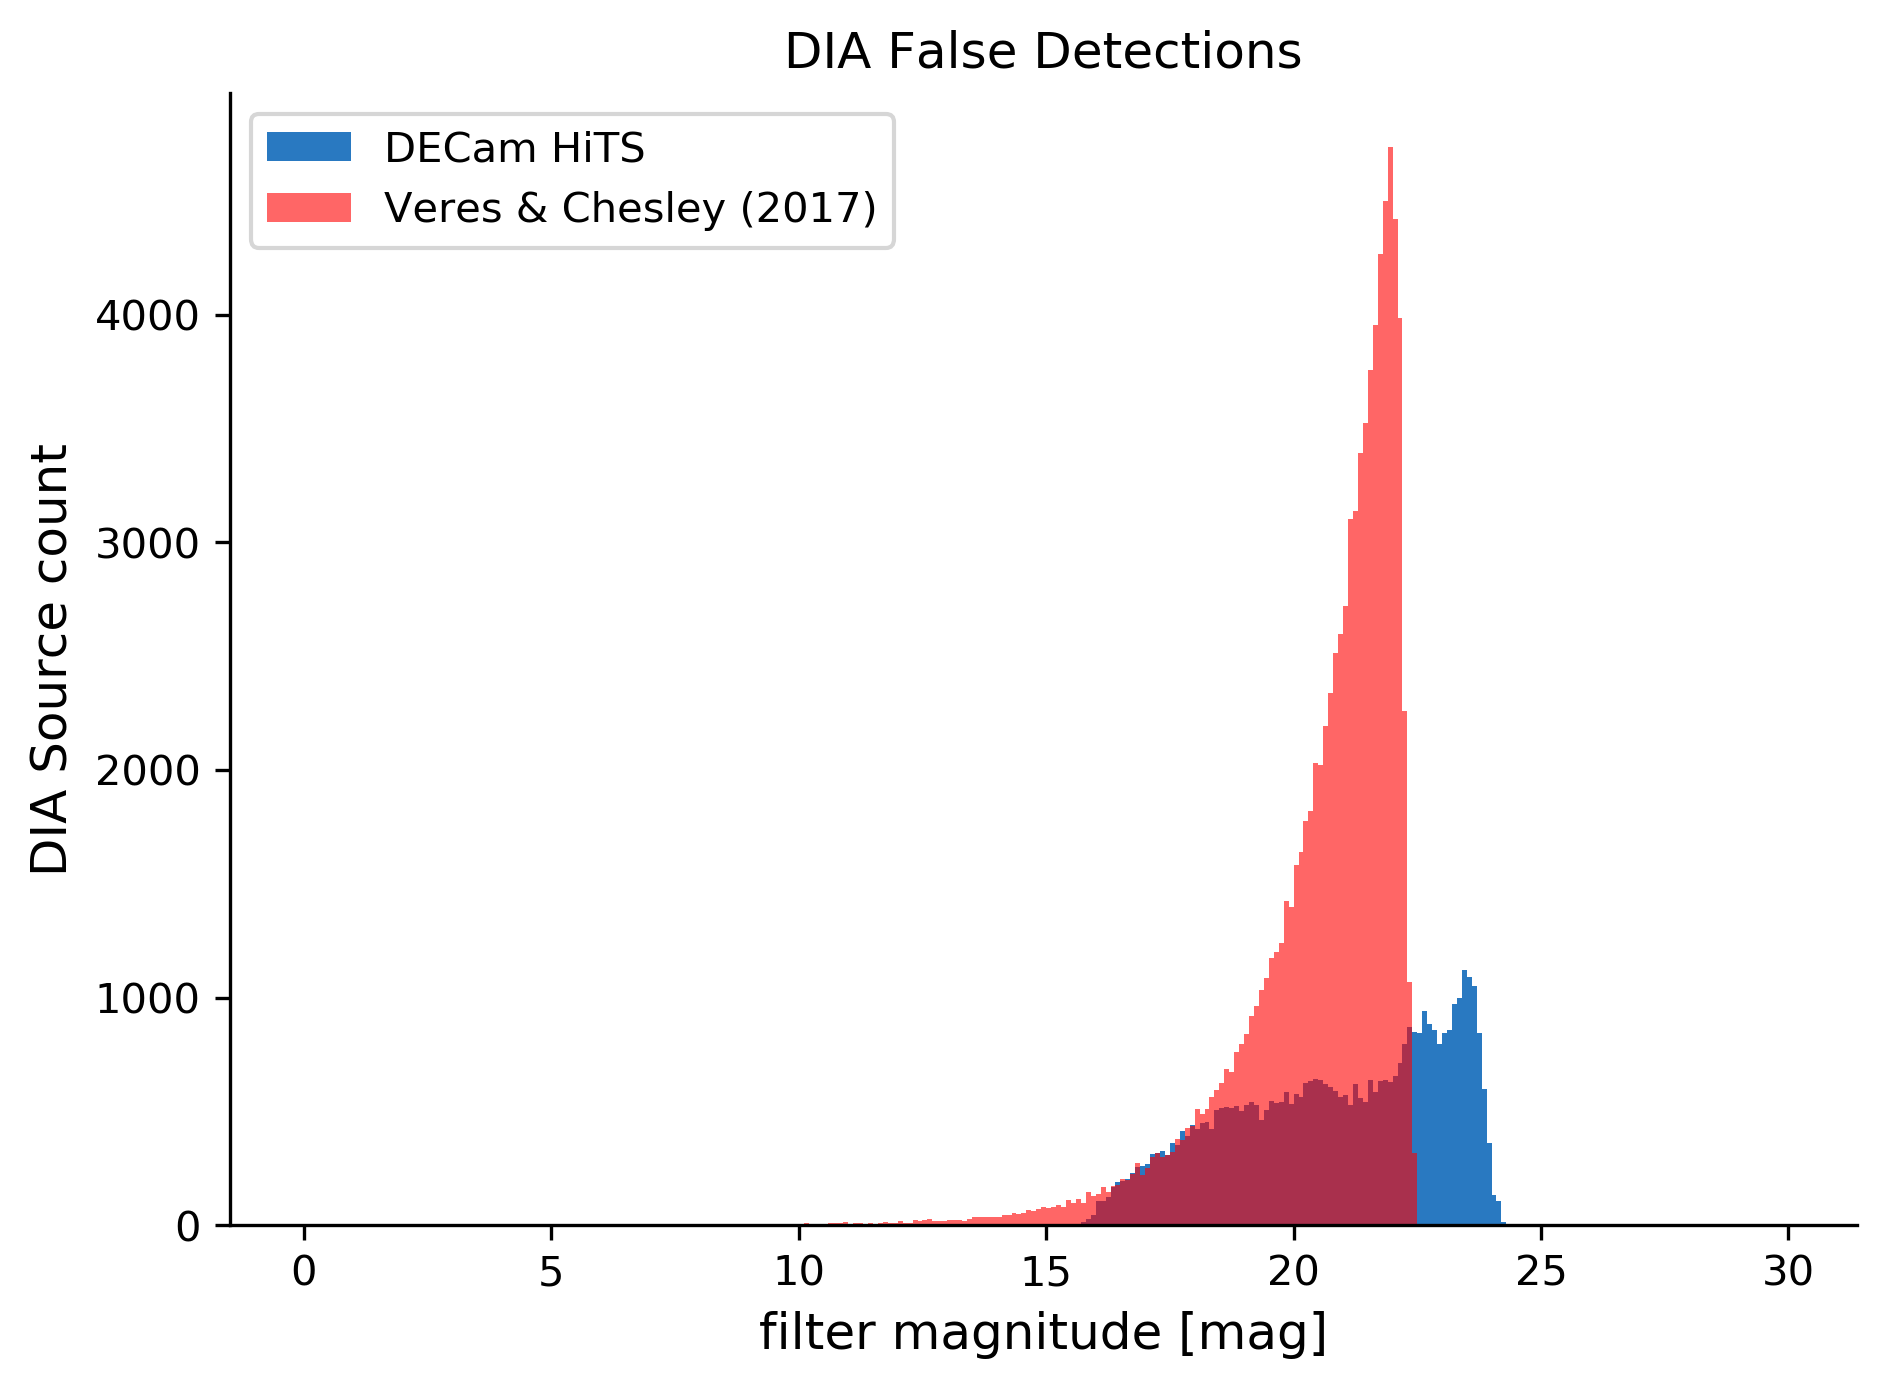

In [67]:
plotNoiseMag(df_5sig,FDdf,fluxType='totFlux', dfVeresMagName='filterMag')

### We will model LSST False Detections based on HiTS data
The number of DIA sources is determined based on seeing and the real/bogus ratio of 1/4.
The mangitude distribution is based on the above HiTS data distribution. 
We first fit the number of DIA sources to the seeing and extrapolate to LSST seeing distribution.


In [40]:
# select year 1 of LSST opsim
LSSTdf=getSqlData(db_path,0,220000)
(LSSTdf.observationStartMJD.max()-LSSTdf.observationStartMJD.min())/365

1.0414905132116448

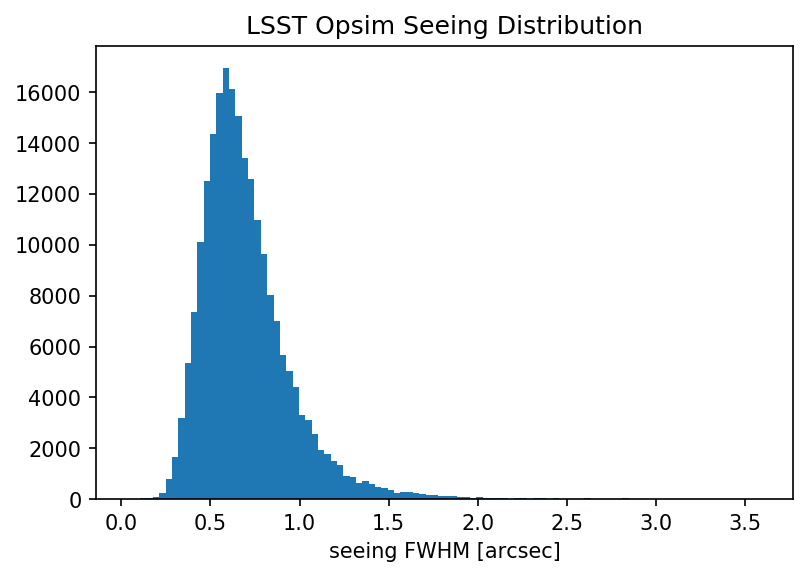

In [41]:
# Plot the seeing distribution
plt.figure(dpi=150)
plt.title('LSST Opsim Seeing Distribution')
LSSTdf.seeingFwhm500.hist(bins=100)
plt.grid(False)
plt.xlabel('seeing FWHM [arcsec]')
plt.show()

In [42]:
# Fit DECam HiTS data and extrapolate to LSST.
xdata = df_dia['median_seeing_arcsec'].values
ydata = df_dia['nDIA_per_visit_per_sq_deg'].values

In [43]:
[xdataR,ydataR,popt,pcov]=fitWithOutlierRejection(fitFunc,xdata,ydata,2,2)

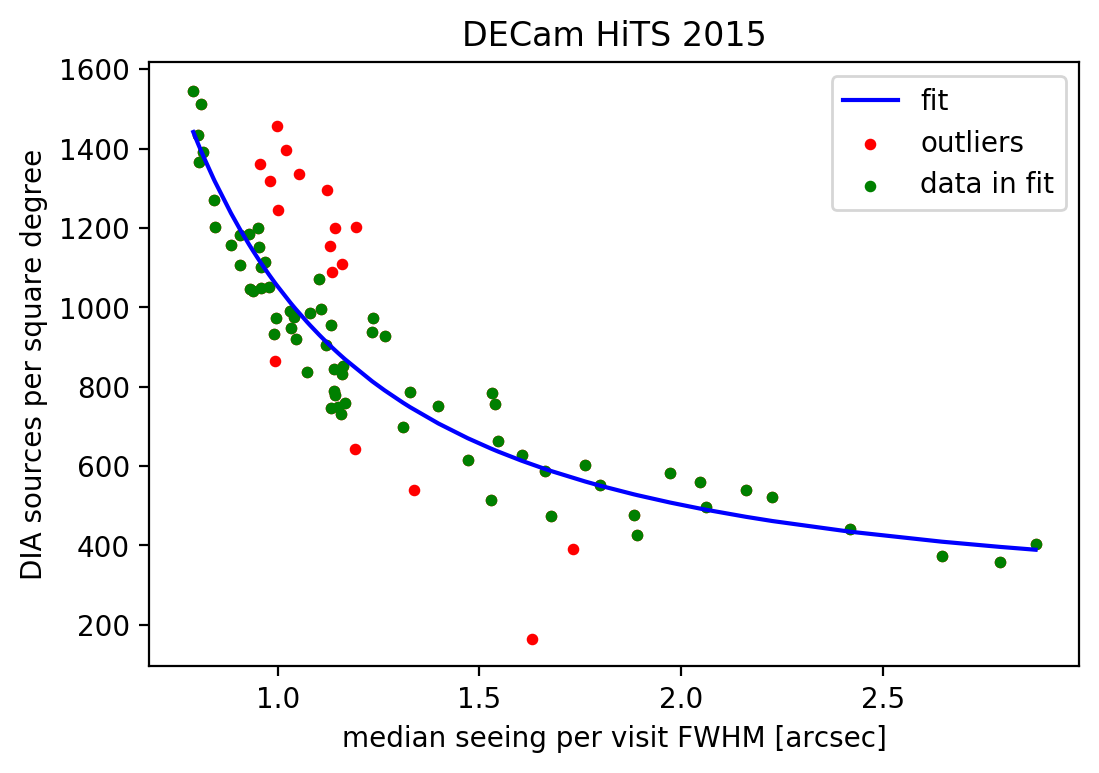

In [44]:
plotFit(fitFunc,xdata,ydata,xdataR,ydataR,popt,
        xlabel='median seeing per visit FWHM [arcsec]', ylabel='DIA sources per square degree', title='DECam HiTS 2015')

In [45]:
LSSTdf=getSqlData(db_path,0,1000)

In [46]:
FDdf, nFDlist =createDiaFalseDetectionsHiTS(LSSTdf, fitFunc, popt, pcov,  kde)

mean, sigma of number of False Detections per square degree 1000 , 316


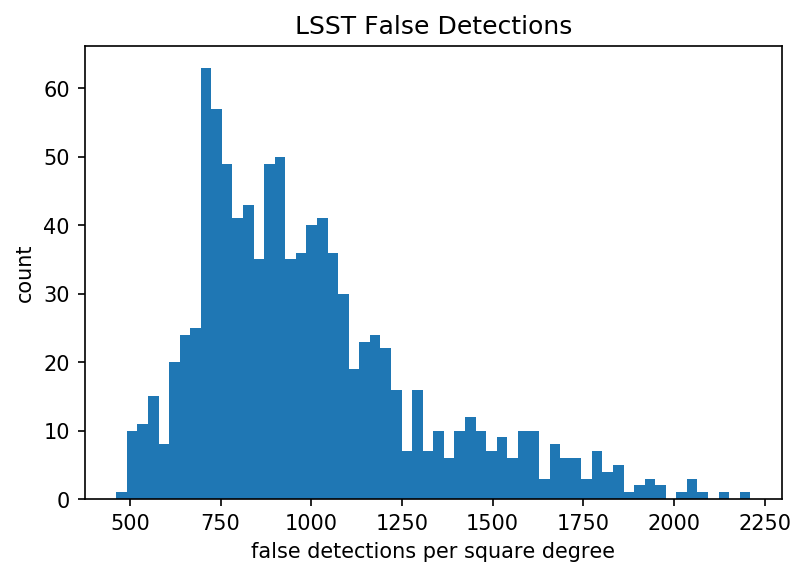

In [47]:
plt.figure(dpi=150)
plt.title('LSST False Detections')
#LSSTdf.seeingFwhm500.hist(bins=100)
plt.hist(nFDlist,bins=60)
plt.grid(False)
plt.xlabel('false detections per square degree')
plt.ylabel('count')
plt.show()

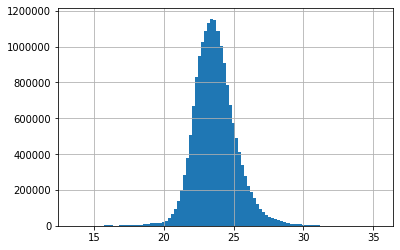

In [48]:
FDdf['Filtermag'].hist(bins=100)

In [49]:
makeFalseDetectionsFiles(0,100,db_path,fitFunc,popt,pcov,kde)

mean, sigma of number of False Detections per square degree 716 , 119


'Ok'

In [301]:
LSSTdf.columns

Index(['observationId', 'fieldRA', 'fieldDec', 'observationStartMJD',
       'flush_by_mjd', 'visitExposureTime', 'filter', 'rotSkyPos',
       'numExposures', 'airmass', 'seeingFwhm500', 'seeingFwhmEff',
       'seeingFwhmGeom', 'skyBrightness', 'night', 'slewTime', 'visitTime',
       'slewDistance', 'fiveSigmaDepth', 'altitude', 'azimuth', 'paraAngle',
       'cloud', 'moonAlt', 'sunAlt', 'note', 'fieldId', 'proposalId',
       'block_id', 'observationStartLST', 'rotTelPos', 'moonAz', 'sunAz',
       'sunRA', 'sunDec', 'moonRA', 'moonDec', 'moonDistance', 'solarElong',
       'moonPhase'],
      dtype='object')

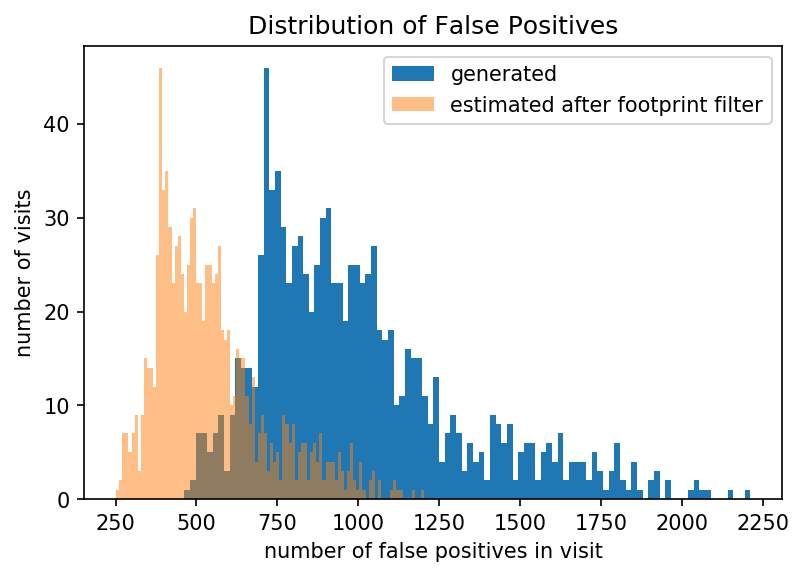

In [56]:
plt.figure(dpi=150)
plt.hist(nFDlist, bins=100, label='generated')
plt.hist(np.array(nFDlist)*9.6/4.2**2, alpha=0.5, bins=100, label='estimated after footprint filter')
plt.title('Distribution of False Positives')
plt.xlabel('number of false positives in visit')
plt.ylabel('number of visits')
plt.legend()
plt.show()

In [318]:
LSSTdf=getSqlData(db_path,0,220000)

In [319]:
delta=500
visit_range=np.arange(0,220000,delta)

In [320]:
visit_range

array([     0,    500,   1000,   1500,   2000,   2500,   3000,   3500,
         4000,   4500,   5000,   5500,   6000,   6500,   7000,   7500,
         8000,   8500,   9000,   9500,  10000,  10500,  11000,  11500,
        12000,  12500,  13000,  13500,  14000,  14500,  15000,  15500,
        16000,  16500,  17000,  17500,  18000,  18500,  19000,  19500,
        20000,  20500,  21000,  21500,  22000,  22500,  23000,  23500,
        24000,  24500,  25000,  25500,  26000,  26500,  27000,  27500,
        28000,  28500,  29000,  29500,  30000,  30500,  31000,  31500,
        32000,  32500,  33000,  33500,  34000,  34500,  35000,  35500,
        36000,  36500,  37000,  37500,  38000,  38500,  39000,  39500,
        40000,  40500,  41000,  41500,  42000,  42500,  43000,  43500,
        44000,  44500,  45000,  45500,  46000,  46500,  47000,  47500,
        48000,  48500,  49000,  49500,  50000,  50500,  51000,  51500,
        52000,  52500,  53000,  53500,  54000,  54500,  55000,  55500,
      

In [321]:
Parallel(n_jobs=10)(delayed(makeFalseDetectionsFiles)(i,delta,db_path) for i in visit_range)

['Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',

In [349]:
Parallel(n_jobs=10)(delayed(makeRandomNoiseFiles)(i,delta,db_path) for i in visit_range)

['Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',

In [59]:
Parallel(n_jobs=8)(delayed(makeFalseDetectionsFiles)(i,delta,db_path,fitFunc,popt,pcov,kde) for i in visit_range)

/epyc/projects/sssc/conda-sssc-env/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


['Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',
 'Ok',

In [64]:
dftest=pd.read_csv('data/false_detections_fbs-v1_5-2snaps_0000000.csv')

In [65]:
dftest

ObjID  observationId      FieldMJD  AstRange(km)  AstRangeRate(km/s)  \
0          FD              0  59853.985644           NaN                 NaN   
1          FD              0  59853.985644           NaN                 NaN   
2          FD              0  59853.985644           NaN                 NaN   
3          FD              0  59853.985644           NaN                 NaN   
4          FD              0  59853.985644           NaN                 NaN   
...       ...            ...           ...           ...                 ...   
5761843    FD            499  59854.213483           NaN                 NaN   
5761844    FD            499  59854.213483           NaN                 NaN   
5761845    FD            499  59854.213483           NaN                 NaN   
5761846    FD            499  59854.213483           NaN                 NaN   
5761847    FD            499  59854.213483           NaN                 NaN   

         AstRA(deg)  AstRARate(deg/day)  AstDec(deg)  AstDecRate(deg/day)  \
0        294.038030                 NaN     5.837662                  NaN   
1        293.254243                 NaN     3.436891                  NaN   
2        294.028695                 NaN     3.684669                  NaN   
3        295.396677                 NaN     3.061928                  NaN   
4        294.954098                 NaN     5.795672                  NaN   
...             ...                 ...          ...                  ...   
5761843  327.022705                 NaN   -69.537817                  NaN   
5761844  325.964364                 NaN   -66.597841                  NaN   
5761845  324.150719                 NaN   -68.462675                  NaN   
5761846  327.174624                 NaN   -67.928414                  NaN   
5761847  327.248792                 NaN   -66.866297                  NaN   

         Ast-Sun(J2000x)(km)  Ast-Sun(J2000y)(km)  Ast-Sun(J2000z)(km)  \
0                        NaN                  NaN                  NaN   
1                        NaN                  NaN                  NaN   
2                        NaN                  NaN                  NaN   
3                        NaN                  NaN                  NaN   
4                        NaN                  NaN                  NaN   
...                      ...                  ...                  ...   
5761843                  NaN                  NaN                  NaN   
5761844                  NaN                  NaN                  NaN   
5761845                  NaN                  NaN                  NaN   
5761846                  NaN                  NaN                  NaN   
5761847                  NaN                  NaN                  NaN   

         Sun-Ast-Obs(deg)   V  Filtermag  V(H=0) Filter  
0                     NaN NaN  19.231647     NaN      z  
1                     NaN NaN  22.980027     NaN      z  
2                     NaN NaN  23.427382     NaN      z  
3                     NaN NaN  24.618437     NaN      z  
4                     NaN NaN  24.015229     NaN      z  
...                   ...  ..        ...     ...    ...  
5761843               NaN NaN  26.486981     NaN      y  
5761844               NaN NaN  22.839282     NaN      y  
5761845               NaN NaN  23.057728     NaN      y  
5761846               NaN NaN  24.914683     NaN      y  
5761847               NaN NaN  24.564391     NaN      y  

[5761848 rows x 17 columns]

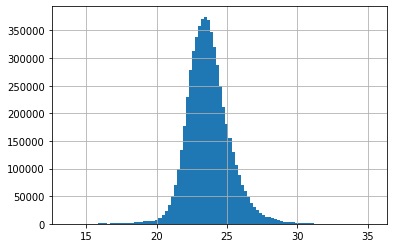

In [66]:
dftest['Filtermag'].hist(bins=100)

In [11]:
!pwd

/astro/store/epyc/projects/jpl_survey_sim/false_detections


In [12]:
import os


In [14]:

#directory = r'C:\Users\admin'
directory = '/astro/store/epyc/projects/jpl_survey_sim/false_detections/data_bu'
for entry in os.scandir(directory):
    if (entry.path.endswith(".csv") and entry.is_file()):
        print(entry.path)
        
        
        

/astro/store/epyc/projects/jpl_survey_sim/false_detections/data_bu/false_detections_fbs-v1_5-2snaps_0000000.csv
/astro/store/epyc/projects/jpl_survey_sim/false_detections/data_bu/false_detections_fbs-v1_5-2snaps_0000500.csv
/astro/store/epyc/projects/jpl_survey_sim/false_detections/data_bu/false_detections_fbs-v1_5-2snaps_0002500.csv
/astro/store/epyc/projects/jpl_survey_sim/false_detections/data_bu/false_detections_fbs-v1_5-2snaps_0002000.csv
/astro/store/epyc/projects/jpl_survey_sim/false_detections/data_bu/false_detections_fbs-v1_5-2snaps_0003000.csv
/astro/store/epyc/projects/jpl_survey_sim/false_detections/data_bu/false_detections_fbs-v1_5-2snaps_0004000.csv
/astro/store/epyc/projects/jpl_survey_sim/false_detections/data_bu/false_detections_fbs-v1_5-2snaps_0003500.csv
/astro/store/epyc/projects/jpl_survey_sim/false_detections/data_bu/false_detections_fbs-v1_5-2snaps_0005500.csv
/astro/store/epyc/projects/jpl_survey_sim/false_detections/data_bu/false_detections_fbs-v1_5-2snaps_0005